In [43]:
import gc
gc.collect()

6052

In [44]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from numpy import save
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time


In [45]:
import sys

sys.path.append("C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project/")

# Import helper functions
from networks import NeuralNetwork
from optimization.optimizers import StochasticGradientDescent, Adam, RMSprop, Adagrad, Adadelta
from networks.loss_functions import CrossEntropy, SquareLoss
from utils.misc import bar_widgets
from networks.layers import Dense, Dropout, Activation, BatchNormalization

from helpers.helper import *
from helpers.processing import *

from Channel.parameters import *
from Channel.transmitor import *
from Channel.modulator import *
from Channel.channel import *
from Channel.equalizer import *
from Channel.demodulator import *
from Channel.detector import *
from nnet_Generator.NNetGenerator import *

In [46]:
# For styling the figures.

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

plt.rcParams["figure.figsize"] = (15,7)

# 2.2 Channel model
### Signal and system parameters

* parameters are defined in the Parameters class

In [107]:
# bandwidth
bandwidth = 1
# Number of symbols
nsymbols = 1
# Size of the constellation
M = 16
# Sample size
Nt = 2**10
# Number of Layers of the Generative network
nLayers = 500
# Number of bits
nb = int(nsymbols * np.log2(M))
# Time mesh
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )

In [108]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
#params = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Modulator
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)
# Initialize the Detector
detector = Detector(transmitor)
# Initialize the Demodulator
demodulator = Demodulator()

### Question 4 : Consider the peak power P=6 mW. Obtain the normalize peak power and plot the constellation C

In [109]:
parameters.power

0.06

In [110]:
parameters.M

16

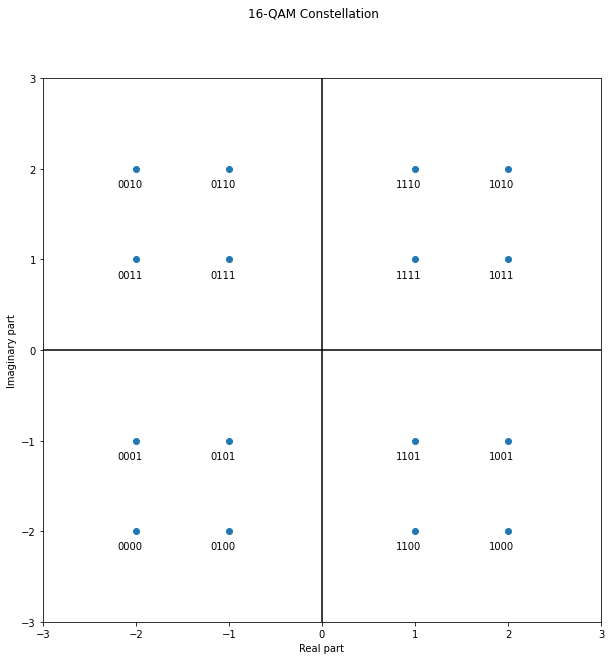

In [111]:
# Constellation
constellation, binary_str, binary_arr = transmitor.build_constellations(parameters.M)
transmitor.plot_constellation(parameters.M, constellation, binary_str)

In [112]:
print(constellation)
print(binary_str)
print(binary_arr)

[-2.-2.j -2.-1.j -2.+2.j -2.+1.j -1.-2.j -1.-1.j -1.+2.j -1.+1.j  2.-2.j
  2.-1.j  2.+2.j  2.+1.j  1.-2.j  1.-1.j  1.+2.j  1.+1.j]
['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]


## 2.2.1 Transmitter

### Question 5. Binary source

In [113]:
print("Probability of 0 : ", parameters.p)
print("Sample size : ", parameters.N)
print("Number of bits : ", parameters.nb)

Probability of 0 :  0.5
Sample size :  1024
Number of bits :  4


In [114]:
#source
b = transmitor.source(parameters.nb , parameters.p)
print("Generated source : \n", b)
print("len(source) : \n", len(b))

Generated source : 
 [1 0 0 1]
len(source) : 
 4


## Modulation
### Question 6. Bits-to-symbols mapping

In [115]:
# symbol sequence
s = transmitor.bit_to_symb(b, parameters.M)
print("symbols : \n", s)
print("len(symbols) : ", len(s))

symbols : 
 [2.-1.j]
len(symbols) :  1


The number of symbols matches the equation : $$ N/\log_{2}(M) = 4/\log_{2}(16) = 1 $$
Where N is the number of bits

### Question 7. Modulation function

In [56]:
q0t = modulator.mod(parameters.t, s, parameters.B)

### Plots in time domain

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

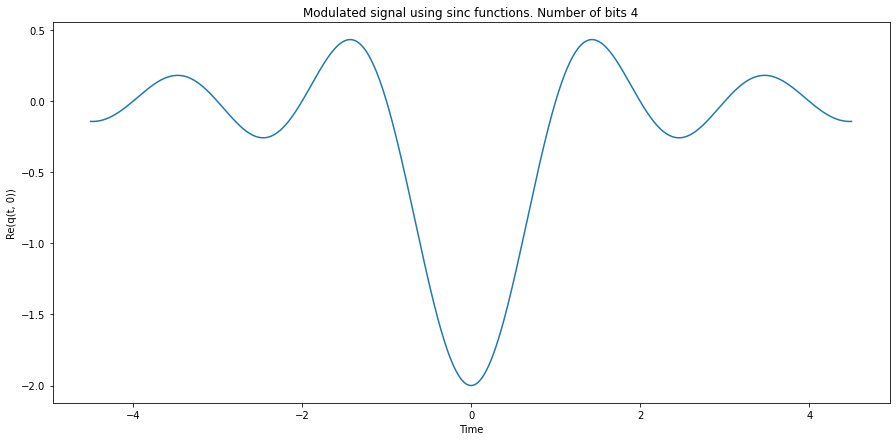

In [57]:
plt.plot(parameters.t, np.squeeze(q0t.real))
plt.xlabel('Time')
plt.ylabel('Re(q(t, 0))')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

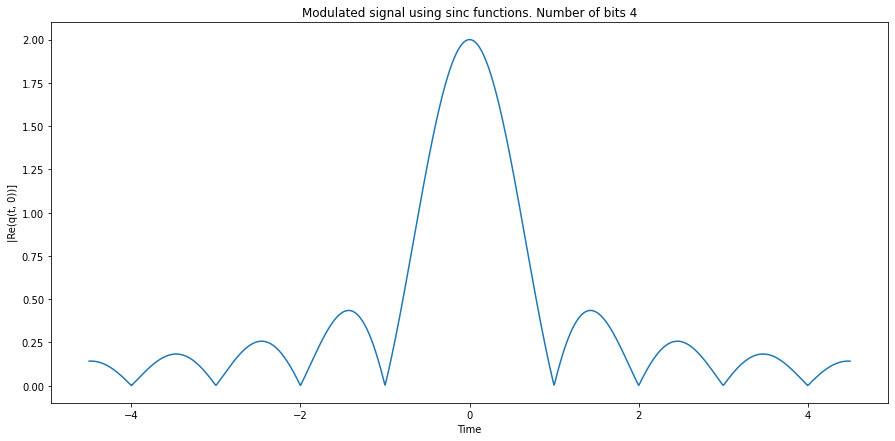

In [58]:
plt.plot(parameters.t, np.abs(np.squeeze(q0t.real)))
plt.xlabel('Time')
plt.ylabel('|Re(q(t, 0))]')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

### Plots in Frequency domain

In [59]:
q0f = np.fft.fft(q0t)
f = np.fft.fftfreq(parameters.N, parameters.dt)

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

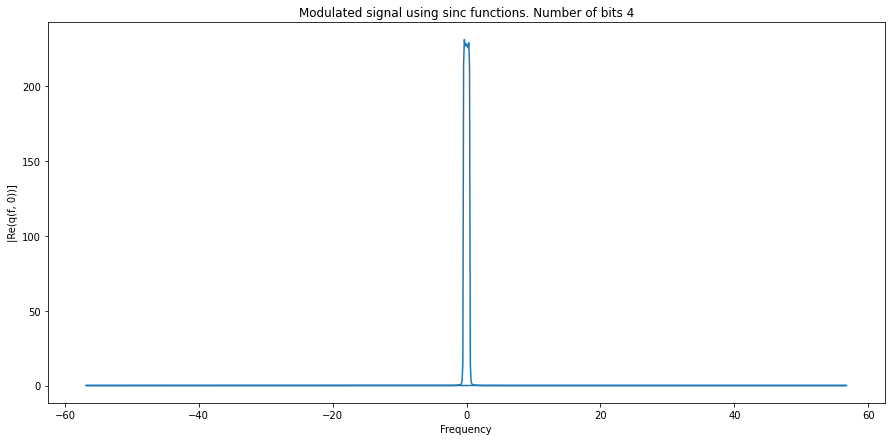

In [60]:
plt.plot(f, np.abs(np.squeeze(q0f.real)))
plt.xlabel('Frequency')
plt.ylabel('|Re(q(f, 0))]')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

## 2.2.2 Channel model

### Question 12. channel(t, q0t, z, sigma2, B) that outputs a realization of the stochastic process q(t,z) given q(t,0).

In [61]:
qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B)

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

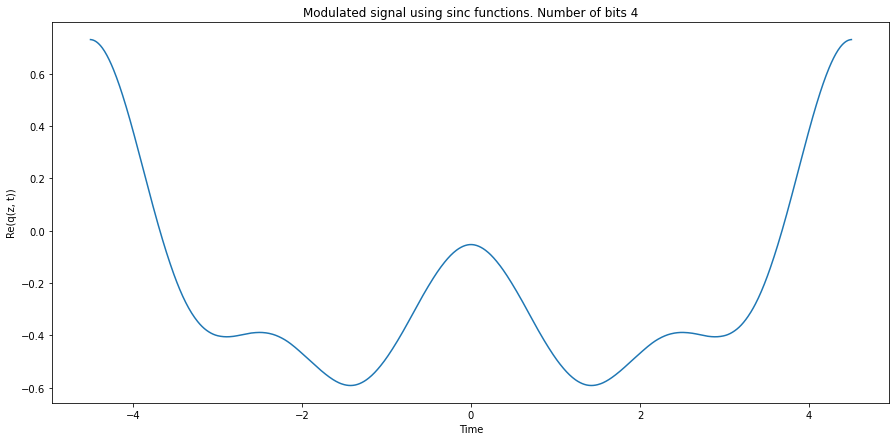

In [62]:
plt.plot(parameters.t, np.squeeze(qzt.real))
plt.xlabel('Time')
plt.ylabel('Re(q(z, t))')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

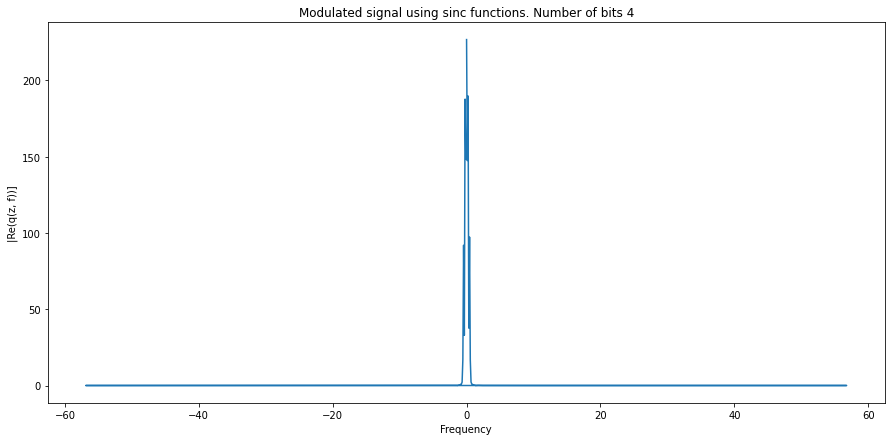

In [63]:
plt.plot(f, np.abs(np.squeeze(qzf.real)))
plt.xlabel('Frequency')
plt.ylabel('|Re(q(z, f))]')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

# 2.2.3 Receiver

## Equalization


**Main**
* We test the equalization part with a Gaussian input signal.


In [64]:
parameters.A

1

In [65]:
q0t = parameters.A*np.exp(-parameters.t**2)
q0f = np.fft.fft(q0t)

Text(0.5, 1.0, 'Gaussian input signal')

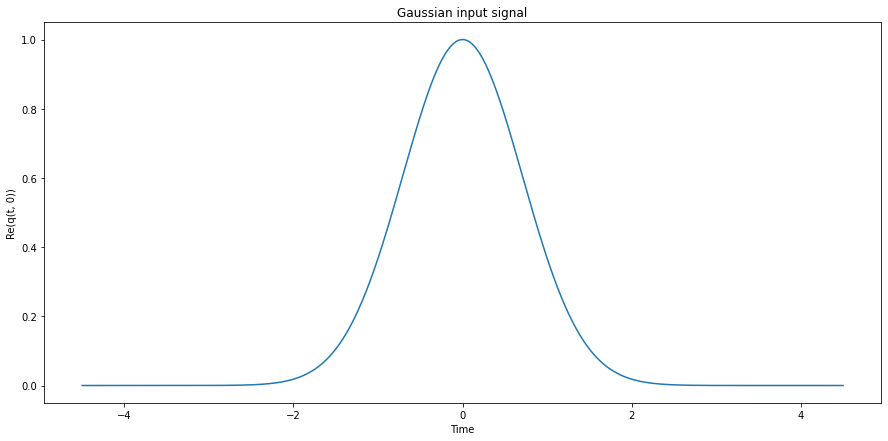

In [66]:
plt.plot(parameters.t, q0t.real)
plt.xlabel('Time')
plt.ylabel('Re(q(t, 0))')
plt.title("Gaussian input signal")

Text(0.5, 1.0, 'Gaussian input signal')

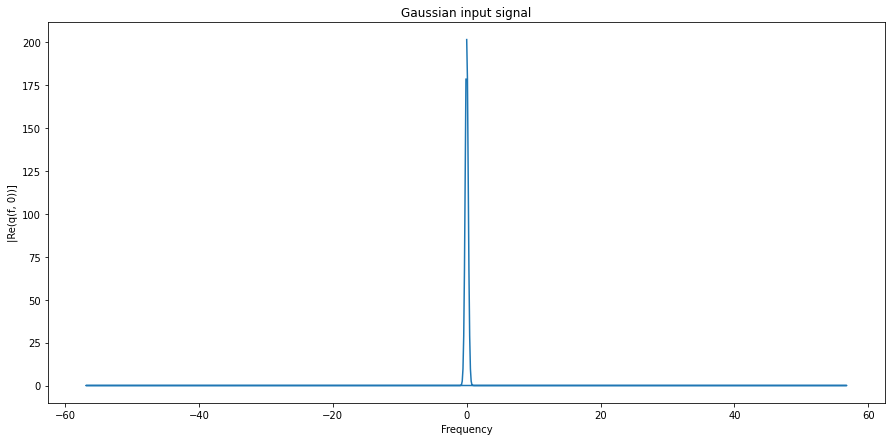

In [67]:
plt.plot(f, np.abs(q0f.real))
plt.xlabel('Frequency')
plt.ylabel('|Re(q(f, 0))]')
plt.title("Gaussian input signal")

In [68]:
# propagation (with zero noise), output in t,f
qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, 0, 0) 
# equalized output
qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z)

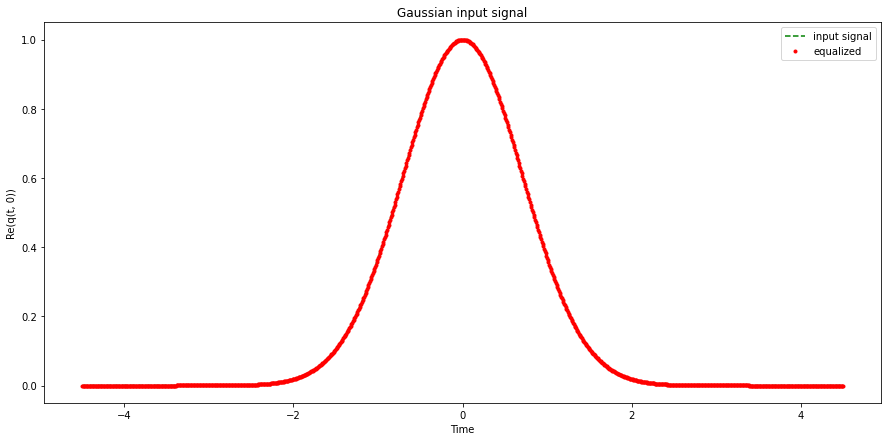

In [69]:
plt.plot(parameters.t, q0t.real, 'g--', label="input signal")
plt.plot(parameters.t, qzte.real, 'r.', label="equalized")

plt.xlabel('Time')
plt.ylabel('Re(q(t, 0))')
plt.title("Gaussian input signal")
plt.legend()

**Comments**

We can see that the equalization is very good, we are able to get back to the original signal. Let's verify this with the comparison function below.

### Comparison of Original and Equalized signals

In [70]:
def compare(x, y):
    """ This function compares the equalized signal with the input one """

    delta = np.absolute(x - y)
    return np.max(delta) <= 1e-10

In [71]:
# we compare the original signal and the equalized one
compare(q0t, qzte) 

True

## Demodulation, Detection and Demapping

### Question 17. Checking the first the **end-to-end implementation when noise is zero**. In this case, we should obtain $ \widehat{s} \approx  s $ with high accuracy

In [72]:
# bandwidth
bandwidth = 1
# Number of symbols
nsymbols = 16
# Size of the constellation
M = 16
# Sample size
Nt = 2**10
# Number of Layers of the Generative network
nLayers = 500
# Number of bits
nb = int(nsymbols * np.log2(M))
# Time mesh
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )

In [73]:
timeMesh

64

In [74]:
print("Number of bits : ", nb)

Number of bits :  64


In [75]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Modulator
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)
# Initialize the Detector
detector = Detector(transmitor)
# Initialize the Demodulator
demodulator = Demodulator()

In [76]:
#source
b = transmitor.source(parameters.nb , parameters.p)

# symbol sequence
s = transmitor.bit_to_symb(b, parameters.M)

# Modulation
q0t = modulator.mod(parameters.t, s, parameters.B)
print("q0t : ", q0t.shape)

# propagation (with zero noise), output in t,f
qzt, qzf = channel.channel(parameters.t, q0t, 100, 0, parameters.B) 
# equalized output
qzte, qzfe = equalizer.equalize(parameters.t, qzt, 100)

print("qzt : ", qzt.shape)
print("qzte : ", qzte.shape)

print("comp : ", compare(q0t, qzte))

# Demodulation
#qzte = qzte.reshape(1,-1) # if Gaussian
shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

# Detection
stilde, indexes = detector.detector(shat, parameters.M)
bhat = detector.symbols_to_bit(indexes, parameters.M)

q0t :  (1, 1024)
qzt :  (1, 1024)
qzte :  (1, 1024)
comp :  True


#### Let's compare the symbol-error-rate and the bit-error-rate

In [77]:
b

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1])

In [78]:
bhat

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1])

In [79]:
ser = detector.ser(s, stilde)  # symbol error rate
ber = detector.ber(b, bhat)  # bit error rate

In [80]:
print("The bit-error-rate is : ",ber)
print("The symbol-error-rate is : ",ser)

The bit-error-rate is :  0.0
The symbol-error-rate is :  0.0


## Inter-symbol interference

For $t_{0} = 4$

In [81]:
A1 = 1
A2 = 2
D = 1
t0 = 4

### z = 0

In [82]:
z = 0
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

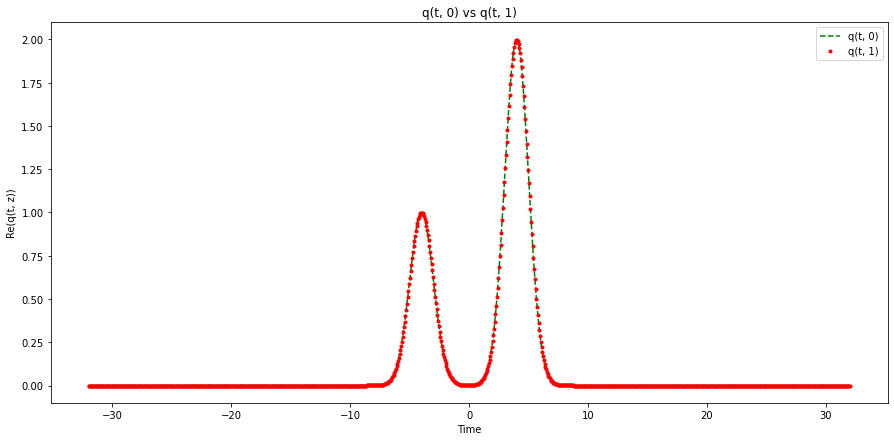

In [83]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r.', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

### z = 1

In [84]:
z = 1
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

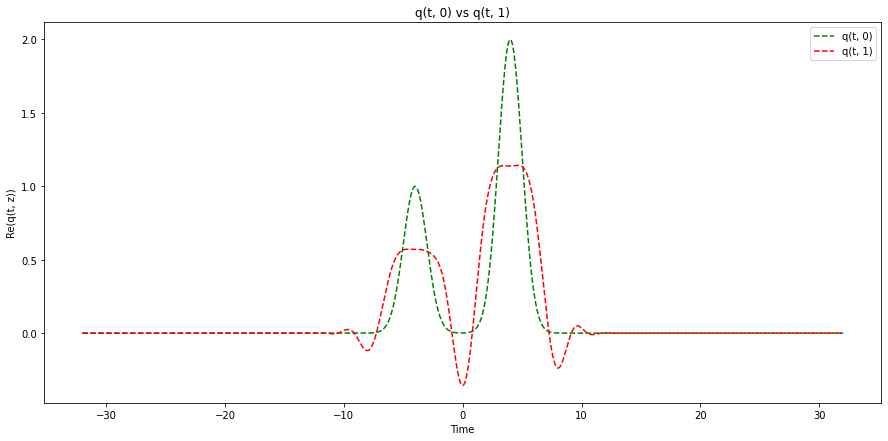

In [85]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

For $t_{0} = 7$

In [86]:
t0 = 7

### z = 0

In [87]:
z= 0
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

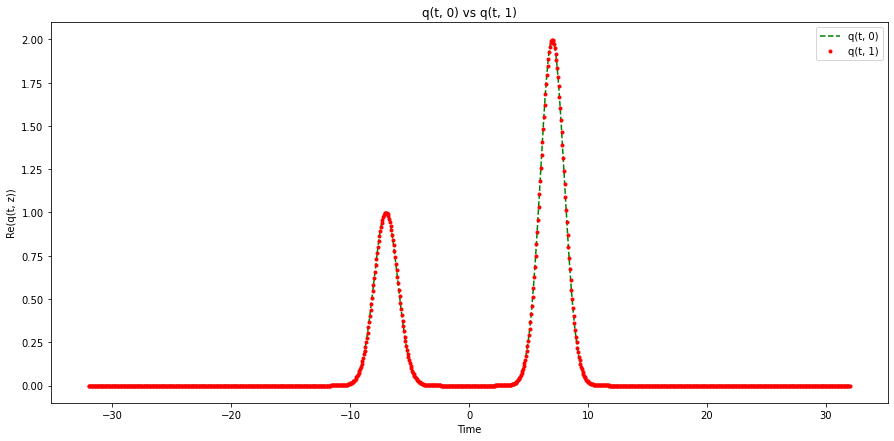

In [88]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r.', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

### z = 1

In [89]:
z= 1
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

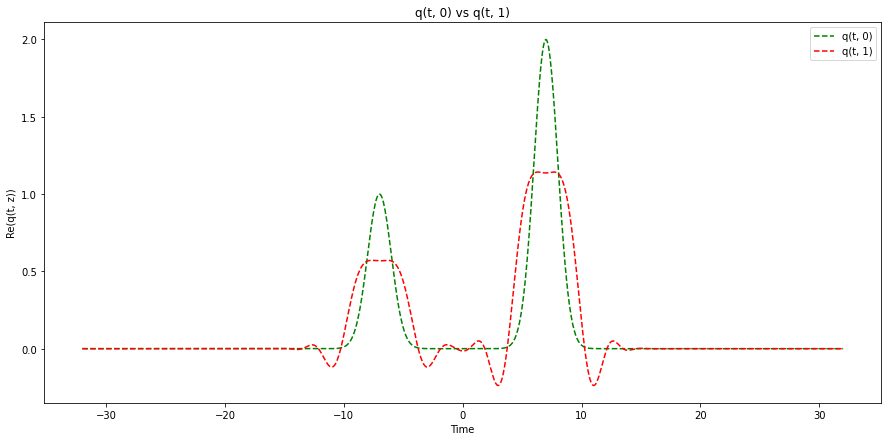

In [90]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

## Equilization

* Let's see if the ISI is completely canceled with equalization.

In [91]:
qt1e, qf1e = equalizer.equalize(parameters.t, qt1, parameters.z)

**In time domain**

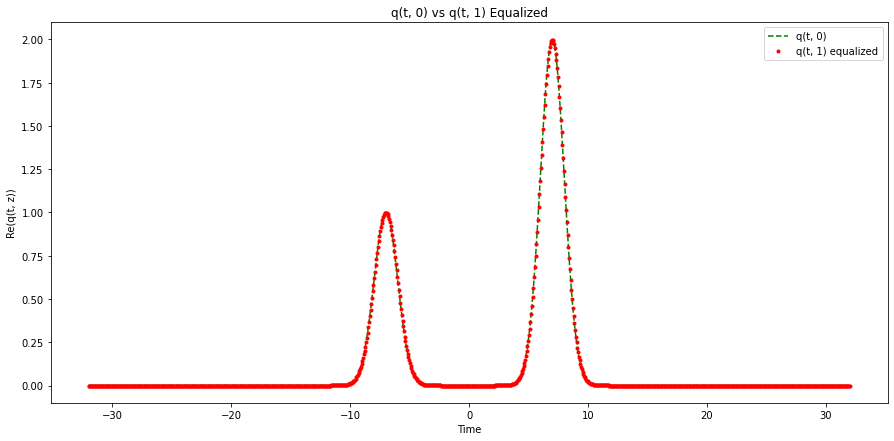

In [92]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1e.real), 'r.', label='q(t, 1) equalized')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1) Equalized')
plt.show()

**In frequency domain**

In [93]:
qf0 = np.fft.fft(qt0)

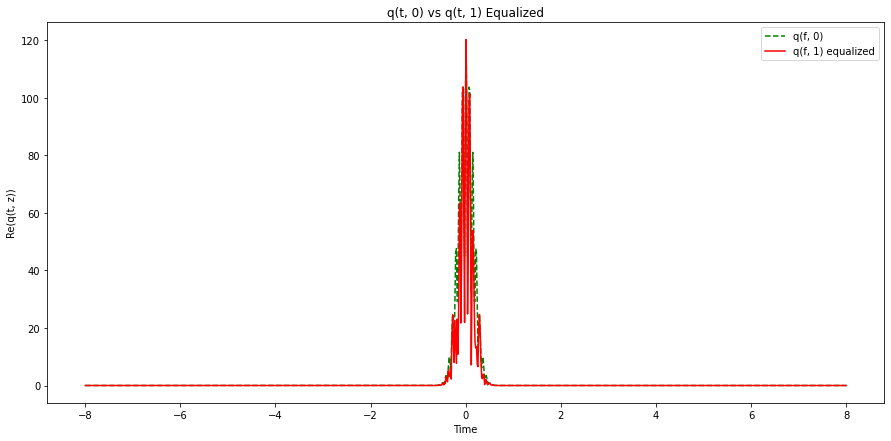

In [94]:
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf0))), 'g--', label='q(f, 0)')
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf1.real))), 'r-', label='q(f, 1) equalized')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1) Equalized')
plt.show()

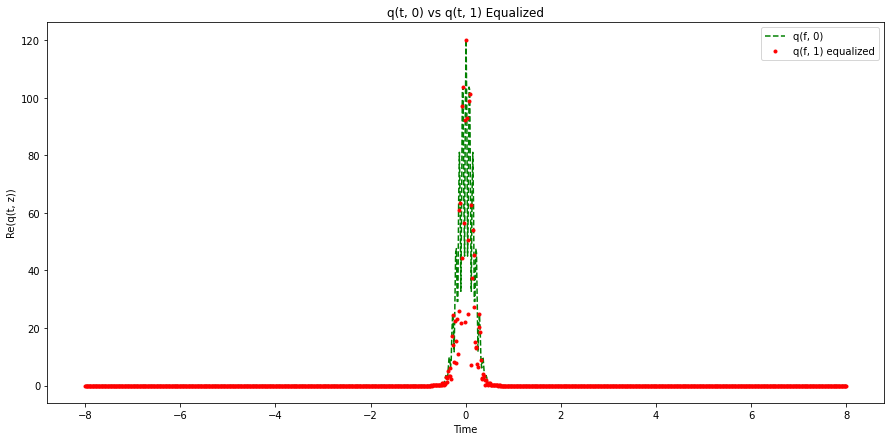

In [95]:
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf0))), 'g--', label='q(f, 0)')
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf1.real))), 'r.', label='q(f, 1) equalized')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1) Equalized')
plt.show()

## 2.2.4 Performance evaluation

### Noisy channel

We now turn to the noisy channel, let's see how the BER evoluate.

In [101]:
def test_performance_noisy_channel(sigma2, z, t0, parameters):
    qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
    qt1, qf1 = channel.channel(parameters.t, qt0, z, sigma2, parameters.B)
    plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
    plt.plot(parameters.t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')
    plt.xlabel('Time')
    plt.ylabel('Re(q(t, z))')
    plt.legend()
    plt.title('q(t, 0) vs q(t, 1)')
    plt.show()

    # equalized output
    qzte, qzfe = equalizer.equalize(parameters.t, qt1, z)

    print("compare(q0t, qzte) : ", compare(q0t, qzte))

    # Demodulation
    qzte = qzte.reshape(1,-1) # if Gaussian
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # Detection
    stilde, indexes = detector.detector(shat, parameters.M)
    bhat = detector.symbols_to_bit(indexes, parameters.M)
    
    ser = detector.ser(s, stilde)  # symbol error rate
    ber = detector.ber(b, bhat)  # bit error rate
    
    print("The bit-error-rate is : ",ber)
    print("The symbol-error-rate is : ",ser)
    return bhat, stilde

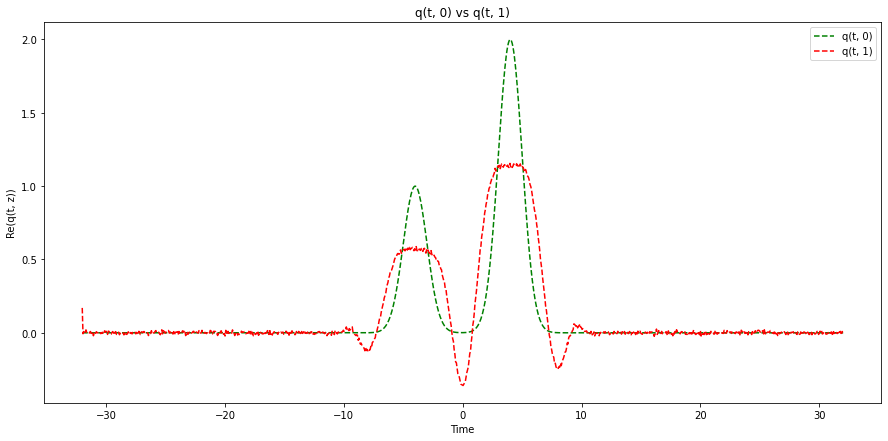

compare(q0t, qzte) :  False
The bit-error-rate is :  0.46875
The symbol-error-rate is :  2.429645737301332


In [104]:
sigma2 = 0.15
z = 1
t0 = 4
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

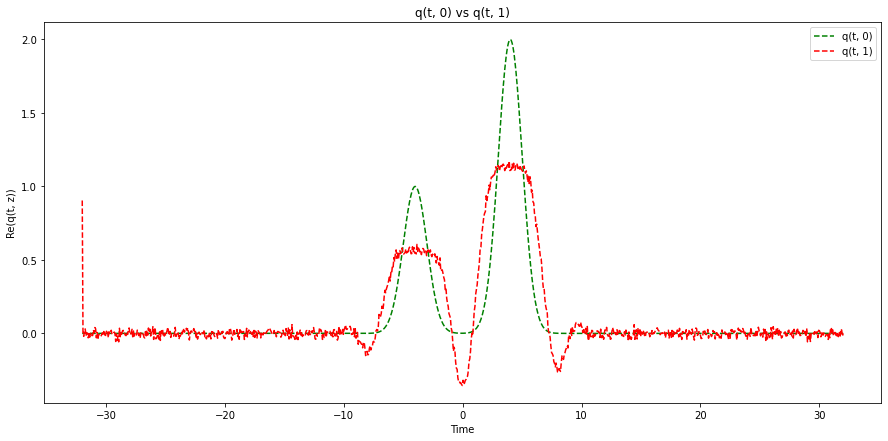

compare(q0t, qzte) :  False
The bit-error-rate is :  0.46875
The symbol-error-rate is :  2.3188313920283883


In [103]:
sigma2 = 0.85
z = 1
t0 = 4
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

## Power in a noisy channel

We should see a degradatation of the power.

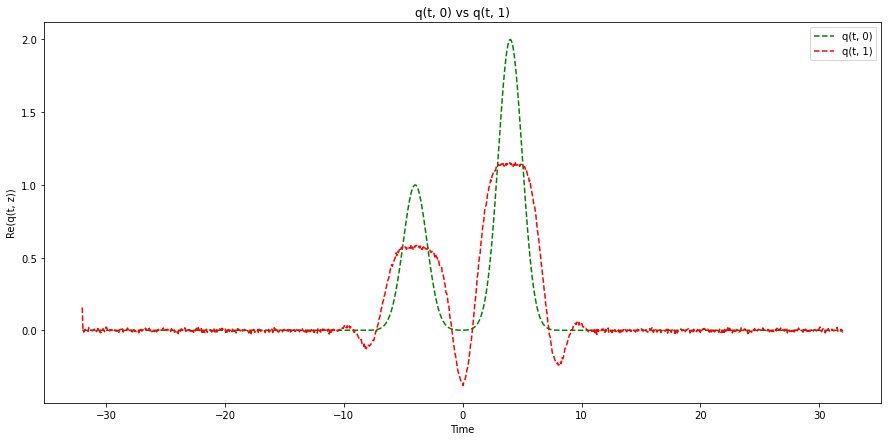

compare(q0t, qzte) :  False
The bit-error-rate is :  0.484375
The symbol-error-rate is :  2.36179801132098


In [283]:
sigma2 = 0.15
z = 1
t0 = 4
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

In [284]:
s

array([-1.+1.j, -2.-1.j, -1.+1.j, -2.-2.j,  2.-2.j,  1.+1.j,  1.-1.j,
       -2.+1.j,  1.+1.j, -2.+1.j, -1.-1.j, -1.+1.j, -1.-2.j,  2.-2.j,
       -2.+1.j,  2.-2.j])

In [285]:
stilde

array([-1.+1.j,  1.+1.j,  1.+1.j,  1.-1.j,  1.-1.j,  1.-1.j,  1.-1.j,
        1.+1.j, -1.+1.j,  1.-1.j,  1.+1.j,  1.-1.j,  2.-1.j,  1.+1.j,
        1.-1.j,  1.-1.j])

In [286]:
compute_signal_power(s, M)

4.437500000000001

In [287]:
compute_signal_power(stilde, M)

2.1875000000000004

## BER vs SNR

We will plot the BER as a function of SNR, for an M-QAM constellation with M = 2, 4, 8, 16 in the same figure.

In [59]:
import statistics

In [104]:
def compute_signal_power(s, M):
    
    if s.ndim > 1 :
        s = np.squeeze(s)
    
    p = 0
    for i in range(len(s)):
        p = p + np.absolute(s[i])**2
    return p/M

def snr(signal_power, noise_power):
    return signal_power/noise_power

def ber_vs_snr_(nbr_experience, list_M, sigmas2):
    
    ber_M = []
    snr_M = []
    dict_M = {}
    
    print("sigmas2 : ", sigmas2)

    for sigma2 in sigmas2:
        
        print("sigma2 : ", sigma2)
        
        for M in tqdm(list_M) :

            # bandwidth
            bandwidth = 1
            # Number of symbols
            nsymbols = 5#10000
            # Sample size
            Nt = 2**10
            # Number of Layers of the Generative network
            nLayers = 500
            # Number of bits
            nb = int(nsymbols * np.log2(M))
            # Time mesh
            timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )
            # Initialize parameters
            parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
            parameters.M = M
            parameters.sigma2 = sigma2
            parameters.nb = nb
            # Initialize the Transmitor
            transmitor = Transmitor()
            # Initialize the Modulator
            modulator = Modulator()
            # Initialize the Channel
            channel = Channel()
            # Initialize the Equalizer
            equalizer = Equalizer()
            # Initialize the NNetGenerator
            nnetGen = NNetGenerator(parameters)
            # Initialize the Detector
            detector = Detector(transmitor)
            # Initialize the Demodulator
            demodulator = Demodulator()

            tmp_snr = []
            tmp_ber = []


            for i in range(nbr_experience):
                #source
                b = transmitor.source(parameters.nb , parameters.p)

                # symbol sequence
                s = transmitor.bit_to_symb(b, M)

                # Modulation
                q0t = modulator.mod(parameters.t, s, parameters.B)

                # propagation (with zero noise), output in t,f
                qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, sigma2, parameters.B)

                # equalized output
                qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z)

                # Demodulation
                shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

                # Detection
                stilde, indexes = detector.detector(shat, M)
                bhat = detector.symbols_to_bit(indexes, M)

                # bit error rate
                ber_value = detector.ber(b, bhat) 

                # Performances
                #signal_power = compute_signal_power(shat, M)
                signal_power = compute_signal_power(s, M)
                noise_power = sigma2 * parameters.B * (parameters.z/parameters.nz)
                snr_value = snr(signal_power, noise_power)

                tmp_snr.append(snr_value)
                tmp_ber.append(ber_value)

            snr_M.append(statistics.mean(tmp_snr))
            ber_M.append(statistics.mean(tmp_ber))
            
            print(dict_M)

            dict_M[M] = dict_M[M].append(statistics.mean(tmp_ber))
            print(dict_M)
    return ber_M, snr_M


def ber_vs_snr(nbr_experience, list_M, sigmas2):
    
    ber_M = []
    snr_M = []
    
    for sigma2 in tqdm(sigmas2):
    
        # bandwidth
        bandwidth = 1
        # Number of symbols
        nsymbols = 5#10000
        # Sample size
        Nt = 2**10
        # Number of Layers of the Generative network
        nLayers = 500
        # Number of bits
        nb = int(nsymbols * np.log2(M))
        # Time mesh
        timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )
        # Initialize parameters
        parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
        parameters.M = M
        parameters.sigma2 = sigma2
        parameters.nb = nb
        # Initialize the Transmitor
        transmitor = Transmitor()
        # Initialize the Modulator
        modulator = Modulator()
        # Initialize the Channel
        channel = Channel()
        # Initialize the Equalizer
        equalizer = Equalizer()
        # Initialize the NNetGenerator
        nnetGen = NNetGenerator(parameters)
        # Initialize the Detector
        detector = Detector(transmitor)
        # Initialize the Demodulator
        demodulator = Demodulator()

        tmp_snr = []
        tmp_ber = []


        for i in range(nbr_experience):
            #source
            b = transmitor.source(parameters.nb , parameters.p)

            # symbol sequence
            s = transmitor.bit_to_symb(b, M)

            # Modulation
            q0t = modulator.mod(parameters.t, s, parameters.B)

            # propagation (with zero noise), output in t,f
            qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, sigma2, parameters.B)

            # equalized output
            qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z)

            # Demodulation
            shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

            # Detection
            stilde, indexes = detector.detector(shat, M)
            bhat = detector.symbols_to_bit(indexes, M)

            # bit error rate
            ber_value = detector.ber(b, bhat) 

            # Performances
            #signal_power = compute_signal_power(shat, M)
            signal_power = compute_signal_power(s, M)
            noise_power = sigma2 * parameters.B * (parameters.z/parameters.nz)
            snr_value = snr(signal_power, noise_power)

            tmp_snr.append(snr_value)
            tmp_ber.append(ber_value)

        snr_M.append(statistics.mean(tmp_snr))
        ber_M.append(statistics.mean(tmp_ber))

    return ber_M, snr_M

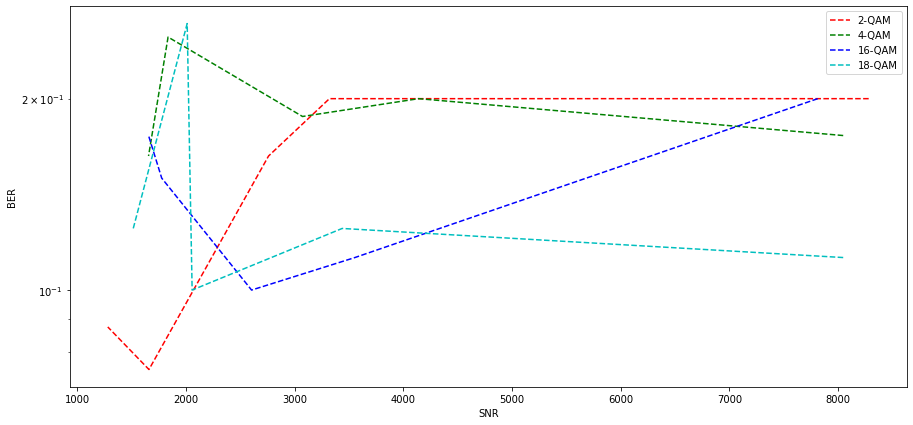

In [111]:
plt.semilogy(sr_2, br_2, 'r--', label="2-QAM")
plt.semilogy(sr_4, br_4, 'g--', label="4-QAM")
plt.semilogy(sr_8, br_8, 'b--', label="16-QAM")
plt.semilogy(sr_16, br_16, 'c--', label="18-QAM")

plt.xlabel("SNR")
plt.ylabel("BER")
plt.legend()
plt.show()

In [ ]:
sigmas2=[0.1,0.2,0.3,0.4,0.5]
nbr_experience = 500
br_2, sr_2 = ber_vs_snr(nbr_experience, 2,sigmas2)
br_4, sr_4 = ber_vs_snr(nbr_experience, 4,sigmas2)
br_8, sr_8 = ber_vs_snr(nbr_experience, 8,sigmas2)
br_16, sr_16 = ber_vs_snr(nbr_experience, 16,sigmas2)

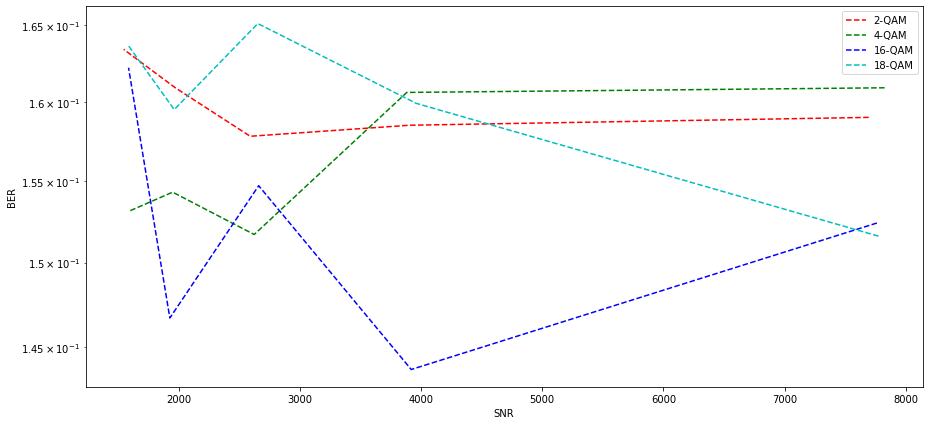

In [118]:
plt.semilogy(sr_2, br_2, 'r--', label="2-QAM")
plt.semilogy(sr_4, br_4, 'g--', label="4-QAM")
plt.semilogy(sr_8, br_8, 'b--', label="16-QAM")
plt.semilogy(sr_16, br_16, 'c--', label="18-QAM")

plt.xlabel("SNR")
plt.ylabel("BER")
plt.legend()
plt.show()

In [119]:
sigmas2=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
nbr_experience = 1000
br_2, sr_2 = ber_vs_snr(nbr_experience, 2,sigmas2)
br_4, sr_4 = ber_vs_snr(nbr_experience, 4,sigmas2)
br_8, sr_8 = ber_vs_snr(nbr_experience, 8,sigmas2)
br_16, sr_16 = ber_vs_snr(nbr_experience, 16,sigmas2)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [16:17<00:00, 108.66s/it]


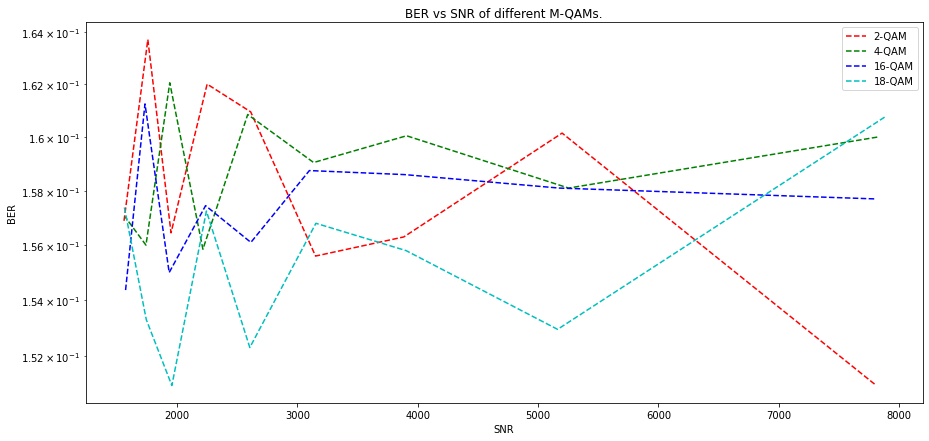

In [122]:
plt.semilogy(sr_2, br_2, 'r--', label="2-QAM")
plt.semilogy(sr_4, br_4, 'g--', label="4-QAM")
plt.semilogy(sr_8, br_8, 'b--', label="16-QAM")
plt.semilogy(sr_16, br_16, 'c--', label="18-QAM")

plt.xlabel("SNR")
plt.ylabel("BER")
plt.title("BER vs SNR of different M-QAMs.")
plt.legend()
plt.show()

In [ ]:
sigmas2=[0.1,0.2,0.3,0.4,0.5]
nbr_experience = 2000
br_2_, sr_2_ = ber_vs_snr(nbr_experience, 2,sigmas2)
br_4_, sr_4_ = ber_vs_snr(nbr_experience, 4,sigmas2)
br_8_, sr_8_ = ber_vs_snr(nbr_experience, 8,sigmas2)
br_16_, sr_16_ = ber_vs_snr(nbr_experience, 16,sigmas2)

In [ ]:
plt.semilogy(sr_2_, br_2_, 'r--', label="2-QAM")
plt.semilogy(sr_4_, br_4_, 'g--', label="4-QAM")
plt.semilogy(sr_8_, br_8_, 'b--', label="16-QAM")
plt.semilogy(sr_16_, br_16_, 'c--', label="18-QAM")

plt.xlabel("SNR")
plt.ylabel("BER")
plt.legend()
plt.show()

In [115]:
br_2

[0.2, 0.2, 0.1625, 0.075, 0.08750000000000001]

In [114]:
br_4

[0.175, 0.19999999999999998, 0.1875, 0.25, 0.1625]

In [112]:
br_8

[0.2, 0.1125, 0.1, 0.15, 0.175]

In [113]:
br_16

[0.1125, 0.125, 0.1, 0.2625, 0.125]

In [102]:
br

[0.15, 0.1875, 0.05, 0.15, 0.1625]

In [382]:
# old implementation
ber_M_noisy, snr_M_noisy = ber_vs_snr_(15, [2,4,8,16],sigma2=0.15)

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [2:19:09<00:00, 2087.44s/it]


In [383]:
ber_M_noisy

[0.49903333333333333, 0.4561, 0.4808222222222222, 0.48877166666666666]

In [384]:
snr_M_noisy

[66666.66666666669, 33333.33333333334, 16666.66666666667, 20824.750000000004]

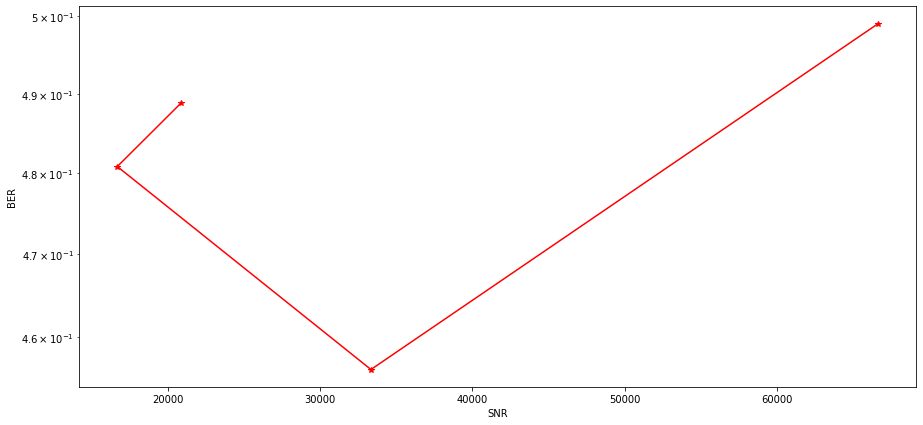

In [388]:
plt.semilogy(snr_M_noisy, ber_M_noisy, 'r*-')
plt.xlabel("SNR")
plt.ylabel("BER")
plt.show()

# 2.3 Generative deep neural network

In [117]:
#source
b = transmitor.source(parameters.nb , parameters.p)

# symbol sequence
s = transmitor.bit_to_symb(b, M)

# Modulation
q0t = modulator.mod(parameters.t, s, parameters.B)

# Neural Net Generator
y_gen = nnetGen.nnet_gen(q0t)

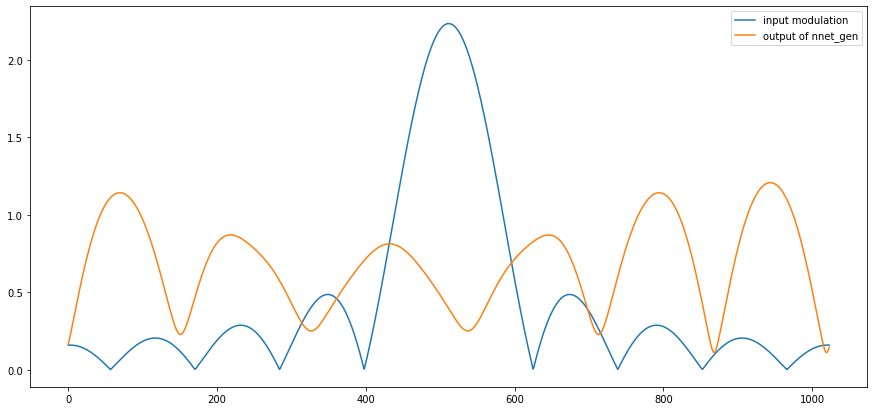

In [118]:
plt.plot(np.squeeze(np.abs(q0t)), label="input modulation")
plt.plot(np.squeeze(np.abs(y_gen)), label="output of nnet_gen")
plt.legend()

# Data Generation

In [21]:
# Generating the dataset
def generateDataset(nbrOfObservations, parameters, transmitor, modulator, nnetGen, demodulator, detector, isGaussian =False):

    X = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)
    y = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)    
    bits_in = np.ndarray((nbrOfObservations, parameters.nb))
    bhat_out = np.ndarray((nbrOfObservations, parameters.nb))
    symb_in = np.ndarray((nbrOfObservations, parameters.n))
    symb_out = np.ndarray((nbrOfObservations, parameters.n))


    print("[INFO] Generating the dataset...")

    for i in tqdm(range(nbrOfObservations)):
        
        # Constellation
        constellation = transmitor.build_constellations(parameters.M)
        
        #source
        source = transmitor.source(parameters.nb , parameters.p) # USE IT FOR NEXT PART OF BITS
        
        # Bits to Symboles - symbol sequence
        bitsToSymbols = transmitor.bit_to_symb(source, parameters.M)

        # symbol sequence, we create a list of values of the complex symbols to use them in modulation
        s = transmitor.bit_to_symb(source, parameters.M)
        
        # channel - we take gaussian input
        if isGaussian:
            q0t = parameters.A*np.exp(-parameters.t**2) 

        else :
            q0t = modulator.mod(parameters.t,s, parameters.B)  
        
        # Neural Net Generator
        y_gen = nnetGen.nnet_gen(q0t)
        # equalized y_gen
        qzte, qzfe = equalizer.equalize(parameters.t, y_gen, parameters.z) # equalized output
        qzte = qzte.reshape(1,-1)
        # demodulation
        shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

        # detection
        stilde, indexes = detector.detector(shat, parameters.M)
        bhat = detector.symbols_to_bit(indexes, parameters.M)
        
        # SOURCE IS THE SEQUENCE OF BITS TO BE LEARNED
        
        # Modulated signal
        X[i] = np.squeeze(q0t)
        # Neural Net Generator
        y[i] = y_gen
        # original bit sequence (source)
        bits_in[i] = source
        # estimated bit sequence
        bhat_out[i] = bhat
        # original symbol sequence (source)

        symb_in[i] = np.squeeze(s)
        # estimated symbol sequence
        symb_out[i] = np.squeeze(shat)
        
    print("[INFO] The dataset is ready now !")

    return X, y, bits_in, bhat_out, symb_in, symb_out

In [22]:
nbrOfObservations = 1500 #(1h for 100 observations)
# bandwidth
bandwidth = 1
# Number of symbols
nsymbols = 16
# Size of the constellation
M = 16
# Sample size
Nt = 2**10
# Number of Layers of the Generative network
nLayers = 500
# Number of bits
nb = int(nsymbols * np.log2(M))
# Time mesh
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )

In [23]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Modulator
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)
# Initialize the Detector
detector = Detector(transmitor)
# Initialize the Demodulator
demodulator = Demodulator()

In [127]:
X, y, bits_in, bhat_out, symb_in, symb_out = generateDataset(nbrOfObservations, parameters, transmitor, modulator, nnetGen, demodulator, detector, isGaussian =False)

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

[INFO] Generating the dataset...


C:\Python36\lib\site-packages\ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Python36\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [09:34<00:00,  2.61it/s]

[INFO] The dataset is ready now !


### Let's see how the data looks like

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 64')

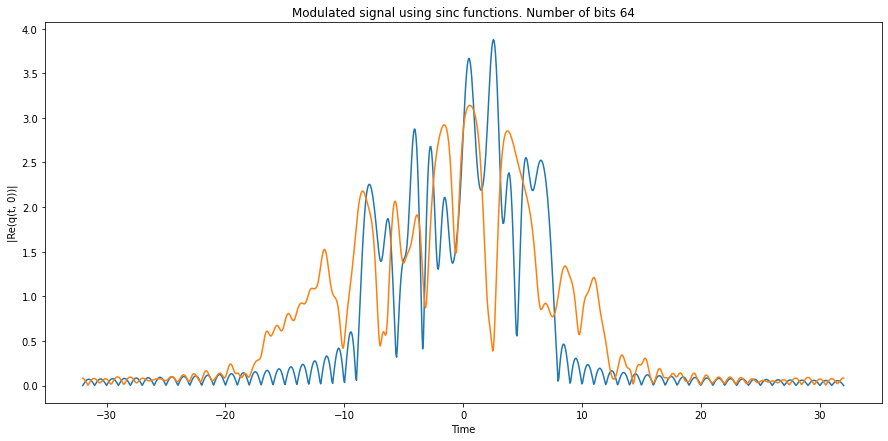

In [134]:
index = 0
plt.plot(parameters.t, np.abs(X[index]))
plt.plot(parameters.t, np.abs(y[index]))
plt.xlabel('Time')
plt.ylabel('|Re(q(t, 0))|')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 64')

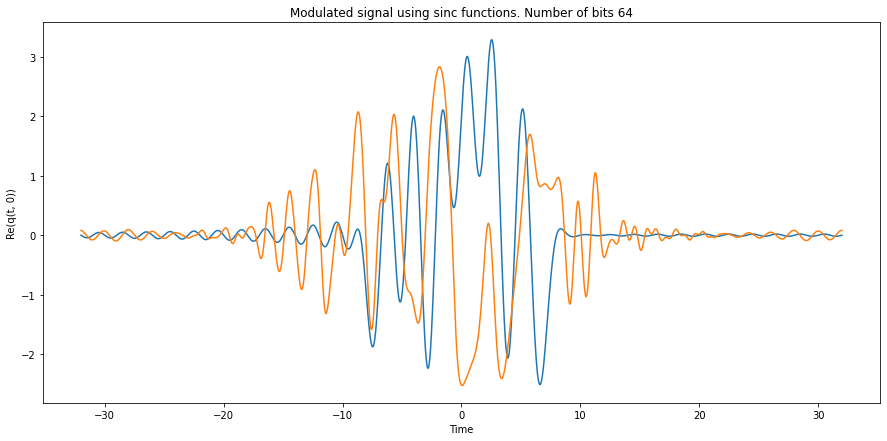

In [133]:
plt.plot(parameters.t, X[index])
plt.plot(parameters.t, y[index])
plt.xlabel('Time')
plt.ylabel('Re(q(t, 0))')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

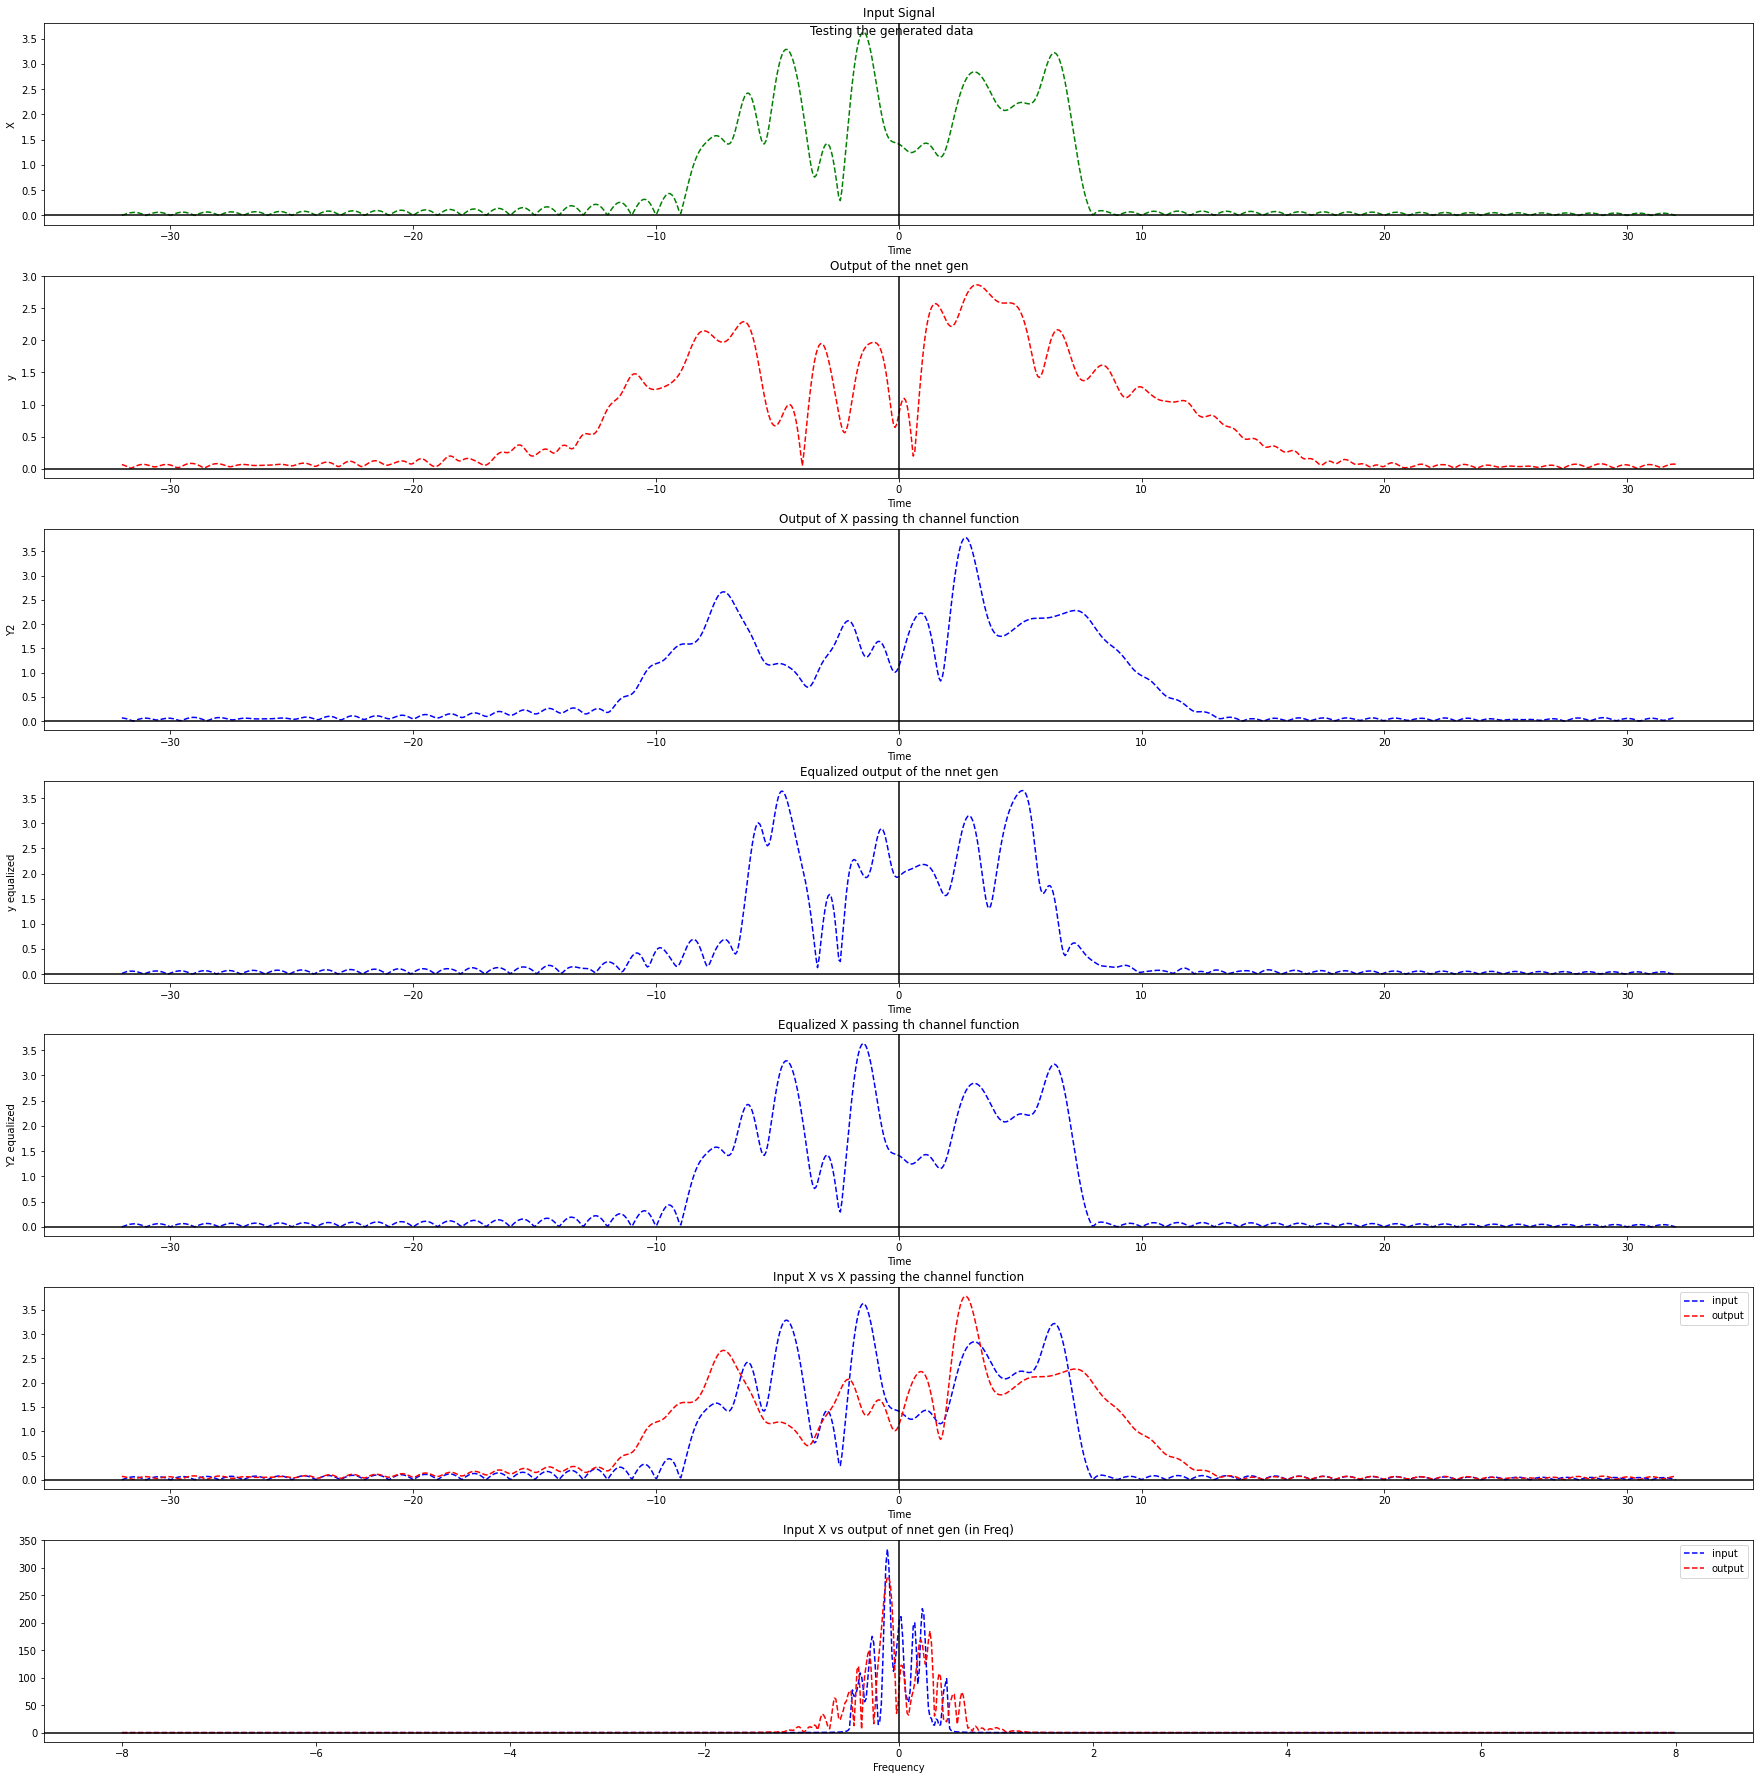

In [26]:
index = 0
test_generated(X, y, index, parameters, channel, equalizer)

# Data preparation

In [138]:
X.shape

(1500, 1024)

In [139]:
t1 = time.time()
# if scaling=True, we are using min-max scaler
df = prepareDataFrame(X, y, scaling=False)
t2 = time.time()
print("Toral time to prepare the dataframe is : ", t2-t1, " seconds.")

  4%|███▍                                                                           | 65/1500 [00:00<00:02, 643.59it/s]


 [INFO] {fromComplexToReal} runing...


  4%|██▉                                                                            | 56/1500 [00:00<00:02, 559.80it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (1500, 2048)

 [INFO] {fromComplexToReal} runing...


100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 672.49it/s]


 [INFO] {fromComplexToReal} vect_real.shape :  (1500, 2048)
{prepareDataFrame} df_.shape :  (1500, 4096)
Toral time to prepare the dataframe is :  4.680044889450073  seconds.


In [140]:
n_samples, n_features = X.shape
n_hidden = 512

In [141]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
[INFO] train and test data are ready.
X.shape :  (1500, 2048)
y.shape :  (1500, 2048)
X_train.shape :  (1125, 2048, 1)
y_train.shape :  (1125, 2048, 1)
X_test.shape :  (375, 2048, 1)
y_test.shape :  (375, 2048, 1)


In [142]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Modeling

In [143]:
def evals(model, X_test, y_test, index_pred, opti, train_err, val_err, nsymbols=16):
    
    # Training and validation error plot
    n = len(train_err)
    training, = plt.plot(range(n), train_err, label="Training Error")
    validation, = plt.plot(range(n), val_err, label="Validation Error")
    plt.legend(handles=[training, validation])
    plt.title("Error Plot using "+str(opti))
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()
    
    y_pred = model.predict(X_test[index_pred])
    
    plt.title("Predicted Signal")
    plt.plot(np.squeeze(np.abs(y_pred)))
    plt.show()
    
    plt.title("Predicted Signal vs Original")
    plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
    plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
    plt.legend()
    plt.show()
    
    evaluate_ber(y_pred, y_test, index_pred, nsymbols)
    
    return y_pred

def evaluate_ber(y_pred, y_test, index_pred, nsymbols):
    
    nLayers = 500                         # Number of Layers of the Generative network
    y_ori = y_test[index_pred]
    # Initialize parameters
    parameters = Parameters(nsymbols=nsymbols, nLayers=nLayers)
    # Initialize the Equalizer
    equalizer = Equalizer()
    # Initialize the Demodulator
    demodulator = Demodulator()
    # Initialize the Transmitor
    transmitor = Transmitor()
    # Initialize the Detector
    detector = Detector(transmitor)
    
    # Predicted signal.
    q0t = fromRealToComplex(y_pred)    
    #qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B) 
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)
    #shat = demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(shat, parameters.M)
    bhat = detector.symbols_to_bit(indexes, parameters.M)
    
    # Original signal.
    y_ori = y_ori.reshape(1,-1)
    q0t = fromRealToComplex(y_ori)
    print(q0t.shape)
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(shat, parameters.M)
    b = detector.symbols_to_bit(indexes, parameters.M)
    
    ser = detector.ser(s, stilde)  # symbol error rate
    ber = detector.ber(b, bhat)  # bit error rate
    
    print("b : ", b)
    print("bhat : ", bhat)
    print("ber : ", ber)
    print("ser : ", ser)

In [152]:
optimizer = Adagrad()
opti = 'Adagrad'
n_features = 2048
n_output = 2048
rect_mlp = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [153]:
rect_mlp.add(Dense(128, input_shape=(n_features,)))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(128))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(128))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(128))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(n_output))
rect_mlp.add(Activation('selu'))

print ()
rect_mlp.summary(name="Rectangular MLP")


+-----------------+
| Rectangular MLP |
+-----------------+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 262272     | (128,)       |
| Activation (SELU)  | 0          | (128,)       |
| Dropout            | 0          | (128,)       |
| BatchNormalization | 256        | (128,)       |
| Dense              | 16512      | (128,)       |
| Activation (SELU)  | 0          | (128,)       |
| Dropout            | 0          | (128,)       |
| BatchNormalization | 256        | (128,)       |
| Dense              | 16512      | (128,)       |
| Activation (SELU)  | 0          | (128,)       |
| Dropout            | 0          | (128,)       |
| BatchNormalization | 256        | (128,)       |
| Dense              | 16512      | (128,)       |
| Activation (SELU)  | 0          | (128,)       |
| Dropout            | 0          | (128,)       |


In [156]:
num_epochs = 250
batch_size = 64

In [157]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  64
[INFO] Training epochs number :  250


[INFO] Training loss on epoch  1  :  0.36391
[INFO] Validation loss on epoch  1  :  0.50684
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.29930
[INFO] Validation loss on epoch  2  :  0.35681
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.28048
[INFO] Validation loss on epoch  3  :  0.30952
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.27075
[INFO] Validation loss on epoch  4  :  0.28385
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.26287
[INFO] Validation loss on epoch  5  :  0.26870
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.25846
[INFO] Validation loss on epoch  6  :  0.26218
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.25370
[INFO] Validation loss on epoch  7  :  0.25640
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.25016
[INFO] Validation loss on epoch  8  :  0.25295
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.24730
[INFO] Validation loss on epoch  9  :  0.25058
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.24432
[INFO] Validation loss on epoch  10  :  0.24831
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.24250
[INFO] Validation loss on epoch  11  :  0.24698
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.24060
[INFO] Validation loss on epoch  12  :  0.24507
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.23901
[INFO] Validation loss on epoch  13  :  0.24467
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.23805
[INFO] Validation loss on epoch  14  :  0.24384
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.23608
[INFO] Validation loss on epoch  15  :  0.24260
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.23494
[INFO] Validation loss on epoch  16  :  0.24222
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.23462
[INFO] Validation loss on epoch  17  :  0.24186
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.23320
[INFO] Validation loss on epoch  18  :  0.24102
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.23183
[INFO] Validation loss on epoch  19  :  0.24033
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.23136
[INFO] Validation loss on epoch  20  :  0.24051
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.23028
[INFO] Validation loss on epoch  21  :  0.24004
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.22930
[INFO] Validation loss on epoch  22  :  0.23999
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.22878
[INFO] Validation loss on epoch  23  :  0.23941
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.22787
[INFO] Validation loss on epoch  24  :  0.23888
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.22703
[INFO] Validation loss on epoch  25  :  0.23877
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.22723
[INFO] Validation loss on epoch  26  :  0.23894
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.22530
[INFO] Validation loss on epoch  27  :  0.23821
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.22411
[INFO] Validation loss on epoch  28  :  0.23784
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.22513
[INFO] Validation loss on epoch  29  :  0.23780
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.22410
[INFO] Validation loss on epoch  30  :  0.23819
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.22448
[INFO] Validation loss on epoch  31  :  0.23716
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.22279
[INFO] Validation loss on epoch  32  :  0.23700
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.22166
[INFO] Validation loss on epoch  33  :  0.23717
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.22061
[INFO] Validation loss on epoch  34  :  0.23680
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.22172
[INFO] Validation loss on epoch  35  :  0.23652
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.22069
[INFO] Validation loss on epoch  36  :  0.23613
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.21973
[INFO] Validation loss on epoch  37  :  0.23585
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.21931
[INFO] Validation loss on epoch  38  :  0.23561
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.21984
[INFO] Validation loss on epoch  39  :  0.23568
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.21920
[INFO] Validation loss on epoch  40  :  0.23566
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  41  :  0.21807
[INFO] Validation loss on epoch  41  :  0.23533
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  42  :  0.21861
[INFO] Validation loss on epoch  42  :  0.23519
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  43  :  0.21727
[INFO] Validation loss on epoch  43  :  0.23490
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  44  :  0.21776
[INFO] Validation loss on epoch  44  :  0.23493
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  45  :  0.21538
[INFO] Validation loss on epoch  45  :  0.23461
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  46  :  0.21758
[INFO] Validation loss on epoch  46  :  0.23441
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  47  :  0.21713
[INFO] Validation loss on epoch  47  :  0.23406
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  48  :  0.21557
[INFO] Validation loss on epoch  48  :  0.23378
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  49  :  0.21684
[INFO] Validation loss on epoch  49  :  0.23396
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  50  :  0.21495
[INFO] Validation loss on epoch  50  :  0.23394
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  51  :  0.21562
[INFO] Validation loss on epoch  51  :  0.23393
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  52  :  0.21502
[INFO] Validation loss on epoch  52  :  0.23381
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  53  :  0.21314
[INFO] Validation loss on epoch  53  :  0.23357
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  54  :  0.21359
[INFO] Validation loss on epoch  54  :  0.23363
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  55  :  0.21421
[INFO] Validation loss on epoch  55  :  0.23341
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  56  :  0.21343
[INFO] Validation loss on epoch  56  :  0.23329
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  57  :  0.21336
[INFO] Validation loss on epoch  57  :  0.23275
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  58  :  0.21177
[INFO] Validation loss on epoch  58  :  0.23315
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  59  :  0.21247
[INFO] Validation loss on epoch  59  :  0.23288
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  60  :  0.21223
[INFO] Validation loss on epoch  60  :  0.23273
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  61  :  0.21221
[INFO] Validation loss on epoch  61  :  0.23281
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  62  :  0.21066
[INFO] Validation loss on epoch  62  :  0.23259
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  63  :  0.21006
[INFO] Validation loss on epoch  63  :  0.23271
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  64  :  0.21092
[INFO] Validation loss on epoch  64  :  0.23217
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  65  :  0.21155
[INFO] Validation loss on epoch  65  :  0.23213
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  66  :  0.21149
[INFO] Validation loss on epoch  66  :  0.23195
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  67  :  0.20985
[INFO] Validation loss on epoch  67  :  0.23207
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  68  :  0.20990
[INFO] Validation loss on epoch  68  :  0.23243
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  69  :  0.20946
[INFO] Validation loss on epoch  69  :  0.23227
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  70  :  0.20997
[INFO] Validation loss on epoch  70  :  0.23242
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  71  :  0.20979
[INFO] Validation loss on epoch  71  :  0.23247
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  72  :  0.20906
[INFO] Validation loss on epoch  72  :  0.23202
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  73  :  0.20891
[INFO] Validation loss on epoch  73  :  0.23223
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  74  :  0.20939
[INFO] Validation loss on epoch  74  :  0.23218
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  75  :  0.20790
[INFO] Validation loss on epoch  75  :  0.23201
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  76  :  0.20846
[INFO] Validation loss on epoch  76  :  0.23189
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  77  :  0.20835
[INFO] Validation loss on epoch  77  :  0.23165
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  78  :  0.20628
[INFO] Validation loss on epoch  78  :  0.23194
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  79  :  0.20722
[INFO] Validation loss on epoch  79  :  0.23158
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  80  :  0.20856
[INFO] Validation loss on epoch  80  :  0.23185
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  81  :  0.20731
[INFO] Validation loss on epoch  81  :  0.23185
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  82  :  0.20659
[INFO] Validation loss on epoch  82  :  0.23188
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  83  :  0.20668
[INFO] Validation loss on epoch  83  :  0.23176
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  84  :  0.20725
[INFO] Validation loss on epoch  84  :  0.23145
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  85  :  0.20569
[INFO] Validation loss on epoch  85  :  0.23124
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  86  :  0.20618
[INFO] Validation loss on epoch  86  :  0.23124
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  87  :  0.20749
[INFO] Validation loss on epoch  87  :  0.23131
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  88  :  0.20596
[INFO] Validation loss on epoch  88  :  0.23092
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  89  :  0.20600
[INFO] Validation loss on epoch  89  :  0.23097
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  90  :  0.20599
[INFO] Validation loss on epoch  90  :  0.23134
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  91  :  0.20450
[INFO] Validation loss on epoch  91  :  0.23134
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  92  :  0.20553
[INFO] Validation loss on epoch  92  :  0.23114
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  93  :  0.20626
[INFO] Validation loss on epoch  93  :  0.23104
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  94  :  0.20632
[INFO] Validation loss on epoch  94  :  0.23112
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  95  :  0.20504
[INFO] Validation loss on epoch  95  :  0.23071
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  96  :  0.20404
[INFO] Validation loss on epoch  96  :  0.23045
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  97  :  0.20476
[INFO] Validation loss on epoch  97  :  0.23066
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  98  :  0.20429
[INFO] Validation loss on epoch  98  :  0.23141
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  99  :  0.20439
[INFO] Validation loss on epoch  99  :  0.23081
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  100  :  0.20335
[INFO] Validation loss on epoch  100  :  0.23038
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  101  :  0.20340
[INFO] Validation loss on epoch  101  :  0.23040
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  102  :  0.20403
[INFO] Validation loss on epoch  102  :  0.23054
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  103  :  0.20254
[INFO] Validation loss on epoch  103  :  0.23032
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  104  :  0.20313
[INFO] Validation loss on epoch  104  :  0.23014
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  105  :  0.20324
[INFO] Validation loss on epoch  105  :  0.23025
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  106  :  0.20321
[INFO] Validation loss on epoch  106  :  0.23022
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  107  :  0.20331
[INFO] Validation loss on epoch  107  :  0.23024
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  108  :  0.20238
[INFO] Validation loss on epoch  108  :  0.23054
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  109  :  0.20328
[INFO] Validation loss on epoch  109  :  0.23073
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  110  :  0.20266
[INFO] Validation loss on epoch  110  :  0.23049
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  111  :  0.20201
[INFO] Validation loss on epoch  111  :  0.23026
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  112  :  0.20250
[INFO] Validation loss on epoch  112  :  0.23024
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  113  :  0.20180
[INFO] Validation loss on epoch  113  :  0.23034
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  114  :  0.20197
[INFO] Validation loss on epoch  114  :  0.23059
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  115  :  0.20218
[INFO] Validation loss on epoch  115  :  0.23016
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  116  :  0.20123
[INFO] Validation loss on epoch  116  :  0.23039
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  117  :  0.20076
[INFO] Validation loss on epoch  117  :  0.23050
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  118  :  0.20172
[INFO] Validation loss on epoch  118  :  0.23011
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  119  :  0.20034
[INFO] Validation loss on epoch  119  :  0.22970
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  120  :  0.20128
[INFO] Validation loss on epoch  120  :  0.22978
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  121  :  0.19999
[INFO] Validation loss on epoch  121  :  0.22989
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  122  :  0.20100
[INFO] Validation loss on epoch  122  :  0.22975
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  123  :  0.20011
[INFO] Validation loss on epoch  123  :  0.22966
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  124  :  0.20012
[INFO] Validation loss on epoch  124  :  0.22969
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  125  :  0.20066
[INFO] Validation loss on epoch  125  :  0.22919
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  126  :  0.20118
[INFO] Validation loss on epoch  126  :  0.22928
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  127  :  0.20174
[INFO] Validation loss on epoch  127  :  0.22935
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  128  :  0.19979
[INFO] Validation loss on epoch  128  :  0.22934
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  129  :  0.19981
[INFO] Validation loss on epoch  129  :  0.22936
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  130  :  0.20020
[INFO] Validation loss on epoch  130  :  0.22908
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  131  :  0.19991
[INFO] Validation loss on epoch  131  :  0.22968
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  132  :  0.19947
[INFO] Validation loss on epoch  132  :  0.22976
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  133  :  0.19950
[INFO] Validation loss on epoch  133  :  0.22949
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  134  :  0.20012
[INFO] Validation loss on epoch  134  :  0.22916
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  135  :  0.19975
[INFO] Validation loss on epoch  135  :  0.22919
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  136  :  0.19923
[INFO] Validation loss on epoch  136  :  0.22899
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  137  :  0.20022
[INFO] Validation loss on epoch  137  :  0.22906
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  138  :  0.19987
[INFO] Validation loss on epoch  138  :  0.22890
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  139  :  0.19873
[INFO] Validation loss on epoch  139  :  0.22906
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  140  :  0.19964
[INFO] Validation loss on epoch  140  :  0.22917
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  141  :  0.19871
[INFO] Validation loss on epoch  141  :  0.22901
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  142  :  0.19946
[INFO] Validation loss on epoch  142  :  0.22915
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  143  :  0.19835
[INFO] Validation loss on epoch  143  :  0.22923
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  144  :  0.19841
[INFO] Validation loss on epoch  144  :  0.22907
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  145  :  0.19787
[INFO] Validation loss on epoch  145  :  0.22904
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  146  :  0.19806
[INFO] Validation loss on epoch  146  :  0.22939
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  147  :  0.19845
[INFO] Validation loss on epoch  147  :  0.22939
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  148  :  0.19834
[INFO] Validation loss on epoch  148  :  0.22938
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  149  :  0.19943
[INFO] Validation loss on epoch  149  :  0.22920
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  150  :  0.19809
[INFO] Validation loss on epoch  150  :  0.22907
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  151  :  0.19795
[INFO] Validation loss on epoch  151  :  0.22895
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  152  :  0.19886
[INFO] Validation loss on epoch  152  :  0.22907
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  153  :  0.19822
[INFO] Validation loss on epoch  153  :  0.22889
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  154  :  0.19638
[INFO] Validation loss on epoch  154  :  0.22892
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  155  :  0.19741
[INFO] Validation loss on epoch  155  :  0.22887
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  156  :  0.19573
[INFO] Validation loss on epoch  156  :  0.22916
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  157  :  0.19789
[INFO] Validation loss on epoch  157  :  0.22901
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  158  :  0.19628
[INFO] Validation loss on epoch  158  :  0.22887
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  159  :  0.19644
[INFO] Validation loss on epoch  159  :  0.22890
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  160  :  0.19706
[INFO] Validation loss on epoch  160  :  0.22919
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  161  :  0.19693
[INFO] Validation loss on epoch  161  :  0.22892
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  162  :  0.19771
[INFO] Validation loss on epoch  162  :  0.22878
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  163  :  0.19681
[INFO] Validation loss on epoch  163  :  0.22920
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  164  :  0.19585
[INFO] Validation loss on epoch  164  :  0.22897
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  165  :  0.19702
[INFO] Validation loss on epoch  165  :  0.22905
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  166  :  0.19618
[INFO] Validation loss on epoch  166  :  0.22904
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  167  :  0.19589
[INFO] Validation loss on epoch  167  :  0.22912
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  168  :  0.19690
[INFO] Validation loss on epoch  168  :  0.22902
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  169  :  0.19575
[INFO] Validation loss on epoch  169  :  0.22905
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  170  :  0.19677
[INFO] Validation loss on epoch  170  :  0.22889
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  171  :  0.19633
[INFO] Validation loss on epoch  171  :  0.22913
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  172  :  0.19660
[INFO] Validation loss on epoch  172  :  0.22899
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  173  :  0.19571
[INFO] Validation loss on epoch  173  :  0.22871
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  174  :  0.19585
[INFO] Validation loss on epoch  174  :  0.22880
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  175  :  0.19590
[INFO] Validation loss on epoch  175  :  0.22905
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  176  :  0.19580
[INFO] Validation loss on epoch  176  :  0.22854
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  177  :  0.19698
[INFO] Validation loss on epoch  177  :  0.22848
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  178  :  0.19589
[INFO] Validation loss on epoch  178  :  0.22857
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  179  :  0.19494
[INFO] Validation loss on epoch  179  :  0.22886
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  180  :  0.19636
[INFO] Validation loss on epoch  180  :  0.22867
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  181  :  0.19617
[INFO] Validation loss on epoch  181  :  0.22842
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  182  :  0.19537
[INFO] Validation loss on epoch  182  :  0.22830
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  183  :  0.19495
[INFO] Validation loss on epoch  183  :  0.22857
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  184  :  0.19573
[INFO] Validation loss on epoch  184  :  0.22859
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  185  :  0.19510
[INFO] Validation loss on epoch  185  :  0.22887
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  186  :  0.19457
[INFO] Validation loss on epoch  186  :  0.22898
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  187  :  0.19508
[INFO] Validation loss on epoch  187  :  0.22877
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  188  :  0.19497
[INFO] Validation loss on epoch  188  :  0.22869
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  189  :  0.19432
[INFO] Validation loss on epoch  189  :  0.22881
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  190  :  0.19366
[INFO] Validation loss on epoch  190  :  0.22889
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  191  :  0.19547
[INFO] Validation loss on epoch  191  :  0.22878
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  192  :  0.19450
[INFO] Validation loss on epoch  192  :  0.22891
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  193  :  0.19329
[INFO] Validation loss on epoch  193  :  0.22887
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  194  :  0.19413
[INFO] Validation loss on epoch  194  :  0.22883
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  195  :  0.19471
[INFO] Validation loss on epoch  195  :  0.22896
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  196  :  0.19431
[INFO] Validation loss on epoch  196  :  0.22906
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  197  :  0.19390
[INFO] Validation loss on epoch  197  :  0.22877
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  198  :  0.19478
[INFO] Validation loss on epoch  198  :  0.22851
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  199  :  0.19516
[INFO] Validation loss on epoch  199  :  0.22845
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  200  :  0.19384
[INFO] Validation loss on epoch  200  :  0.22881
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  201  :  0.19269
[INFO] Validation loss on epoch  201  :  0.22867
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  202  :  0.19373
[INFO] Validation loss on epoch  202  :  0.22867
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  203  :  0.19347
[INFO] Validation loss on epoch  203  :  0.22852
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  204  :  0.19404
[INFO] Validation loss on epoch  204  :  0.22855
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  205  :  0.19287
[INFO] Validation loss on epoch  205  :  0.22880
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  206  :  0.19337
[INFO] Validation loss on epoch  206  :  0.22872
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  207  :  0.19269
[INFO] Validation loss on epoch  207  :  0.22892
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  208  :  0.19255
[INFO] Validation loss on epoch  208  :  0.22903
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  209  :  0.19304
[INFO] Validation loss on epoch  209  :  0.22926
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  210  :  0.19270
[INFO] Validation loss on epoch  210  :  0.22866
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  211  :  0.19367
[INFO] Validation loss on epoch  211  :  0.22870
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  212  :  0.19315
[INFO] Validation loss on epoch  212  :  0.22898
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  213  :  0.19285
[INFO] Validation loss on epoch  213  :  0.22917
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  214  :  0.19349
[INFO] Validation loss on epoch  214  :  0.22897
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  215  :  0.19372
[INFO] Validation loss on epoch  215  :  0.22890
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  216  :  0.19179
[INFO] Validation loss on epoch  216  :  0.22902
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  217  :  0.19250
[INFO] Validation loss on epoch  217  :  0.22868
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  218  :  0.19248
[INFO] Validation loss on epoch  218  :  0.22866
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  219  :  0.19185
[INFO] Validation loss on epoch  219  :  0.22867
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  220  :  0.19381
[INFO] Validation loss on epoch  220  :  0.22886
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  221  :  0.19256
[INFO] Validation loss on epoch  221  :  0.22857
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  222  :  0.19060
[INFO] Validation loss on epoch  222  :  0.22851
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  223  :  0.19218
[INFO] Validation loss on epoch  223  :  0.22864
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  224  :  0.19013
[INFO] Validation loss on epoch  224  :  0.22883
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  225  :  0.19196
[INFO] Validation loss on epoch  225  :  0.22871
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  226  :  0.19292
[INFO] Validation loss on epoch  226  :  0.22865
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  227  :  0.19156
[INFO] Validation loss on epoch  227  :  0.22880
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  228  :  0.19115
[INFO] Validation loss on epoch  228  :  0.22880
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  229  :  0.19213
[INFO] Validation loss on epoch  229  :  0.22877
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  230  :  0.19268
[INFO] Validation loss on epoch  230  :  0.22877
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  231  :  0.19235
[INFO] Validation loss on epoch  231  :  0.22882
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  232  :  0.19071
[INFO] Validation loss on epoch  232  :  0.22884
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  233  :  0.19183
[INFO] Validation loss on epoch  233  :  0.22902
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  234  :  0.19181
[INFO] Validation loss on epoch  234  :  0.22875
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  235  :  0.19091
[INFO] Validation loss on epoch  235  :  0.22842
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  236  :  0.19136
[INFO] Validation loss on epoch  236  :  0.22831
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  237  :  0.19250
[INFO] Validation loss on epoch  237  :  0.22851
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  238  :  0.19124
[INFO] Validation loss on epoch  238  :  0.22822
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  239  :  0.19191
[INFO] Validation loss on epoch  239  :  0.22821
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  240  :  0.19197
[INFO] Validation loss on epoch  240  :  0.22841
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  241  :  0.19050
[INFO] Validation loss on epoch  241  :  0.22841
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  242  :  0.19077
[INFO] Validation loss on epoch  242  :  0.22861
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  243  :  0.18974
[INFO] Validation loss on epoch  243  :  0.22821
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  244  :  0.19172
[INFO] Validation loss on epoch  244  :  0.22834
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  245  :  0.19135
[INFO] Validation loss on epoch  245  :  0.22863
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  246  :  0.19136
[INFO] Validation loss on epoch  246  :  0.22858
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  247  :  0.19188
[INFO] Validation loss on epoch  247  :  0.22845
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  248  :  0.19063
[INFO] Validation loss on epoch  248  :  0.22852
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  249  :  0.19086
[INFO] Validation loss on epoch  249  :  0.22837
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  250  :  0.19005
[INFO] Validation loss on epoch  250  :  0.22838
-------------------------------------------------------------------------------


## Performance evaluation of the model

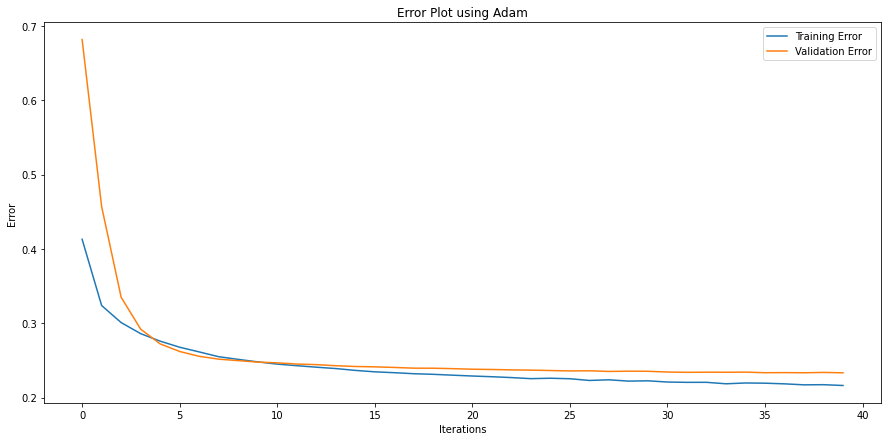

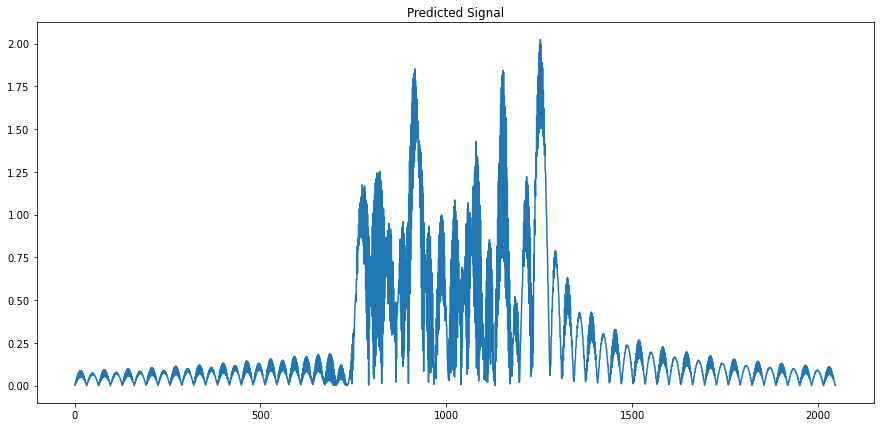

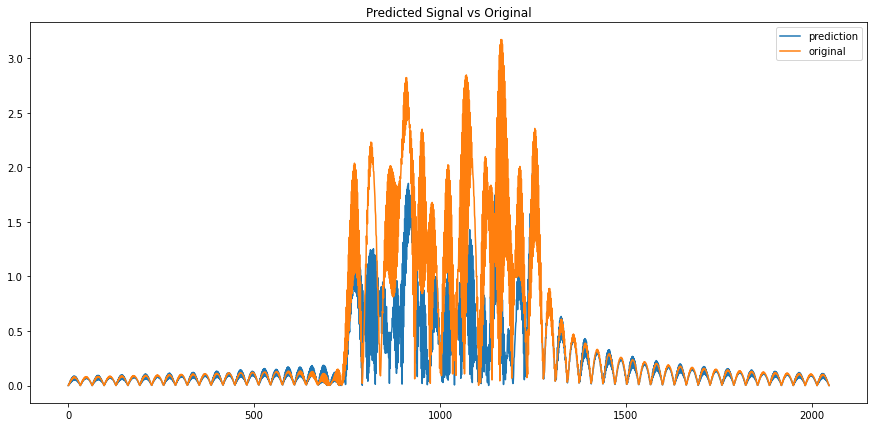

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.57it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.75it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
(1, 1024)


b :  [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1]
bhat :  [0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1]
ber :  0.265625
ser :  2.9768358096461336


In [151]:
index_pred= 0
y_pred = evals(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect, nsymbols=parameters.n)

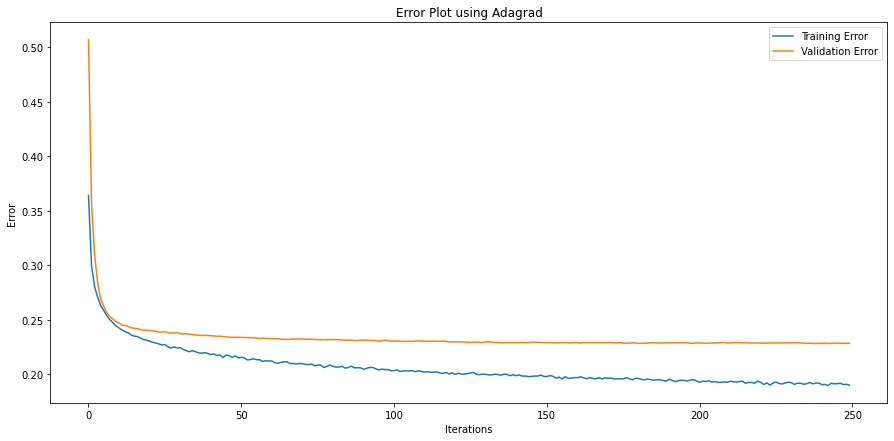

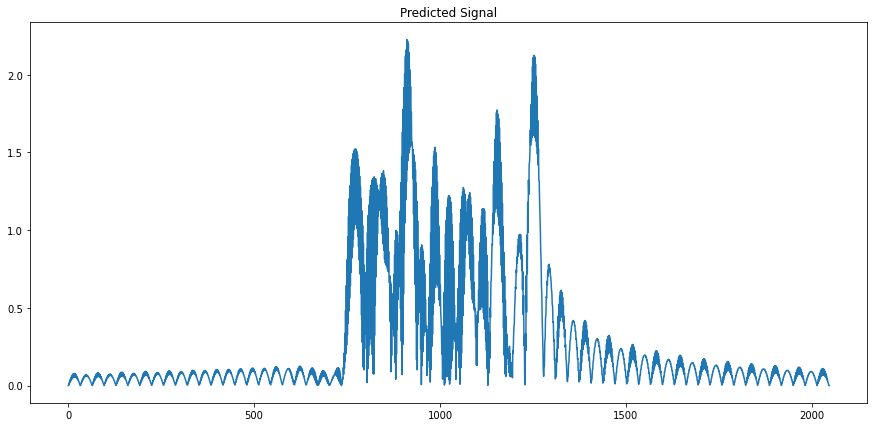

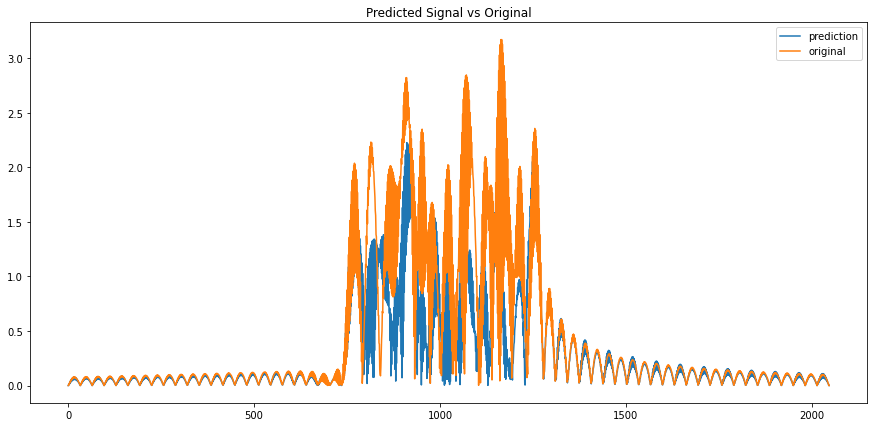

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.43it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.94it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
(1, 1024)


b :  [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1]
bhat :  [0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
ber :  0.25
ser :  2.9768358096461336


In [158]:
index_pred= 0
y_pred = evals(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect, nsymbols=parameters.n)

## With Phase Activation

In [166]:
optimizer = Adagrad()
opti = 'Adagrad'
n_features = 2048
n_output = 2048
rect_mlp = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [167]:
rect_mlp.add(Dense(128, input_shape=(n_features,)))
rect_mlp.add(Activation('phase_activation'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(128))
rect_mlp.add(Activation('phase_activation'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(128))
rect_mlp.add(Activation('phase_activation'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(128))
rect_mlp.add(Activation('phase_activation'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(n_output))
rect_mlp.add(Activation('phase_activation'))

print ()
rect_mlp.summary(name="Rectangular MLP")


+-----------------+
| Rectangular MLP |
+-----------------+
Input Shape: (2048,)
+------------------------------+------------+--------------+
| Layer Type                   | Parameters | Output Shape |
+------------------------------+------------+--------------+
| Dense                        | 262272     | (128,)       |
| Activation (PhaseActivation) | 0          | (128,)       |
| Dropout                      | 0          | (128,)       |
| BatchNormalization           | 256        | (128,)       |
| Dense                        | 16512      | (128,)       |
| Activation (PhaseActivation) | 0          | (128,)       |
| Dropout                      | 0          | (128,)       |
| BatchNormalization           | 256        | (128,)       |
| Dense                        | 16512      | (128,)       |
| Activation (PhaseActivation) | 0          | (128,)       |
| Dropout                      | 0          | (128,)       |
| BatchNormalization           | 256        | (128,)       |
| D

In [168]:
num_epochs = 25
batch_size = 64

In [169]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  64
[INFO] Training epochs number :  25


[INFO] Training loss on epoch  1  :  0.36760
[INFO] Validation loss on epoch  1  :  0.38991
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.32089
[INFO] Validation loss on epoch  2  :  0.29703
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.30575
[INFO] Validation loss on epoch  3  :  0.28224
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.29780
[INFO] Validation loss on epoch  4  :  0.27576
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.29274
[INFO] Validation loss on epoch  5  :  0.27037
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.28913
[INFO] Validation loss on epoch  6  :  0.26909
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28579
[INFO] Validation loss on epoch  7  :  0.26725
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.28207
[INFO] Validation loss on epoch  8  :  0.26599
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.28058
[INFO] Validation loss on epoch  9  :  0.26691
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.27923
[INFO] Validation loss on epoch  10  :  0.26524
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.27731
[INFO] Validation loss on epoch  11  :  0.26790
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.27734
[INFO] Validation loss on epoch  12  :  0.26745
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.27614
[INFO] Validation loss on epoch  13  :  0.26607
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.27327
[INFO] Validation loss on epoch  14  :  0.26330
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.27137
[INFO] Validation loss on epoch  15  :  0.26306
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.27172
[INFO] Validation loss on epoch  16  :  0.26359
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.27148
[INFO] Validation loss on epoch  17  :  0.26506
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.26983
[INFO] Validation loss on epoch  18  :  0.26284
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.26976
[INFO] Validation loss on epoch  19  :  0.26339
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.26890
[INFO] Validation loss on epoch  20  :  0.26179
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.26796
[INFO] Validation loss on epoch  21  :  0.26208
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.26748
[INFO] Validation loss on epoch  22  :  0.26089
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.26782
[INFO] Validation loss on epoch  23  :  0.26502
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.26879
[INFO] Validation loss on epoch  24  :  0.26423
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.26717
[INFO] Validation loss on epoch  25  :  0.26280
-------------------------------------------------------------------------------


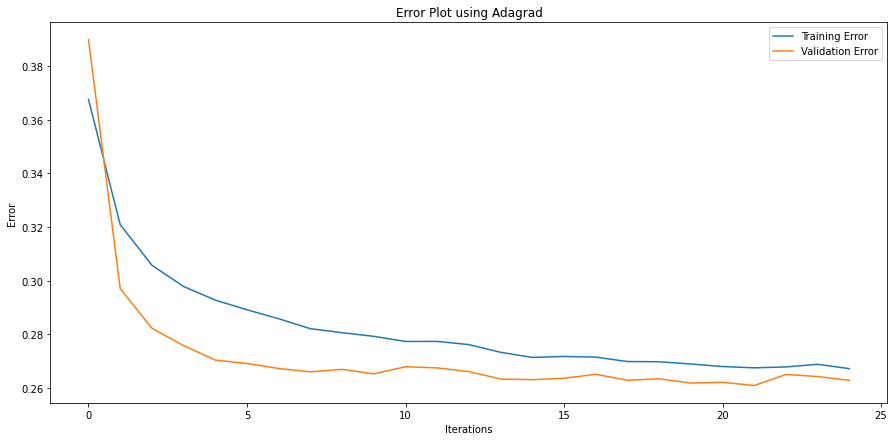

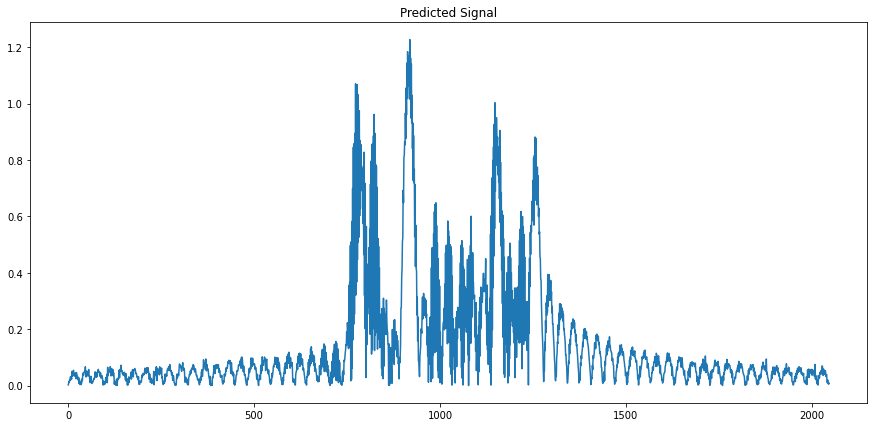

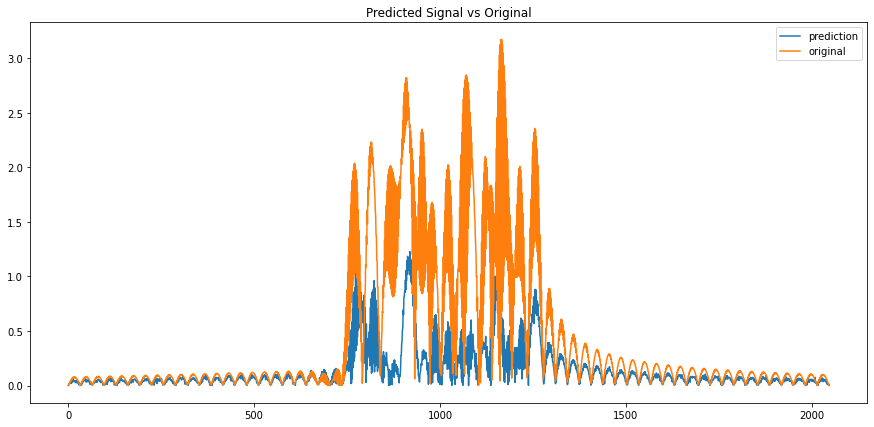

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.99it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.02it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
(1, 1024)


b :  [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1]
bhat :  [0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1]
ber :  0.296875
ser :  2.9768358096461336


In [170]:
index_pred= 0
y_pred = evals(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect, nsymbols=parameters.n)

### When we increase a lot the epochs, the network becomes unstable !

In [162]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  64
[INFO] Training epochs number :  250


[INFO] Training loss on epoch  1  :  0.36891
[INFO] Validation loss on epoch  1  :  0.39060
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.31872
[INFO] Validation loss on epoch  2  :  0.29927
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.30406
[INFO] Validation loss on epoch  3  :  0.28457
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.29795
[INFO] Validation loss on epoch  4  :  0.27700
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.29262
[INFO] Validation loss on epoch  5  :  0.27062
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.28768
[INFO] Validation loss on epoch  6  :  0.26500
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28366
[INFO] Validation loss on epoch  7  :  0.26409
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.28260
[INFO] Validation loss on epoch  8  :  0.26646
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.28238
[INFO] Validation loss on epoch  9  :  0.26496
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.27797
[INFO] Validation loss on epoch  10  :  0.26549
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.27858
[INFO] Validation loss on epoch  11  :  0.26712
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.27695
[INFO] Validation loss on epoch  12  :  0.26639
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.27671
[INFO] Validation loss on epoch  13  :  0.26761
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.27527
[INFO] Validation loss on epoch  14  :  0.26541
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.27262
[INFO] Validation loss on epoch  15  :  0.26389
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.27175
[INFO] Validation loss on epoch  16  :  0.26606
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.27244
[INFO] Validation loss on epoch  17  :  0.26559
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.27089
[INFO] Validation loss on epoch  18  :  0.26449
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.27080
[INFO] Validation loss on epoch  19  :  0.26382
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.27067
[INFO] Validation loss on epoch  20  :  0.26383
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.27085
[INFO] Validation loss on epoch  21  :  0.26357
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.26845
[INFO] Validation loss on epoch  22  :  0.26250
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.26731
[INFO] Validation loss on epoch  23  :  0.26210
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.26761
[INFO] Validation loss on epoch  24  :  0.26221
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.26712
[INFO] Validation loss on epoch  25  :  0.26189
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.26637
[INFO] Validation loss on epoch  26  :  0.26148
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.26646
[INFO] Validation loss on epoch  27  :  0.26158
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.26557
[INFO] Validation loss on epoch  28  :  0.26238
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.26585
[INFO] Validation loss on epoch  29  :  0.26197
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.26670
[INFO] Validation loss on epoch  30  :  0.26120
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.26617
[INFO] Validation loss on epoch  31  :  0.26154
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.26515
[INFO] Validation loss on epoch  32  :  0.26044
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.26550
[INFO] Validation loss on epoch  33  :  0.26044
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.26519
[INFO] Validation loss on epoch  34  :  0.26041
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.26430
[INFO] Validation loss on epoch  35  :  0.25987
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.26407
[INFO] Validation loss on epoch  36  :  0.26027
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.26381
[INFO] Validation loss on epoch  37  :  0.26105
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.26457
[INFO] Validation loss on epoch  38  :  0.26045
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.26444
[INFO] Validation loss on epoch  39  :  0.26093
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.26366
[INFO] Validation loss on epoch  40  :  0.26065
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  41  :  0.26361
[INFO] Validation loss on epoch  41  :  0.25941
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  42  :  0.26294
[INFO] Validation loss on epoch  42  :  0.25841
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  43  :  0.26287
[INFO] Validation loss on epoch  43  :  0.25858
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  44  :  0.26213
[INFO] Validation loss on epoch  44  :  0.25848
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  45  :  0.26171
[INFO] Validation loss on epoch  45  :  0.25872
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  46  :  0.26188
[INFO] Validation loss on epoch  46  :  0.25919
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  47  :  0.26275
[INFO] Validation loss on epoch  47  :  0.25906
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  48  :  0.26235
[INFO] Validation loss on epoch  48  :  0.25943
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  49  :  0.26180
[INFO] Validation loss on epoch  49  :  0.25916
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  50  :  0.26112
[INFO] Validation loss on epoch  50  :  0.25927
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  51  :  0.26110
[INFO] Validation loss on epoch  51  :  0.25918
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  52  :  0.26267
[INFO] Validation loss on epoch  52  :  0.25993
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  53  :  0.26254
[INFO] Validation loss on epoch  53  :  0.26033
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  54  :  0.26106
[INFO] Validation loss on epoch  54  :  0.25934
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  55  :  0.26133
[INFO] Validation loss on epoch  55  :  0.25942
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  56  :  0.26194
[INFO] Validation loss on epoch  56  :  0.26052
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  57  :  0.26149
[INFO] Validation loss on epoch  57  :  0.26030
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  58  :  0.26214
[INFO] Validation loss on epoch  58  :  0.26032
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  59  :  0.26211
[INFO] Validation loss on epoch  59  :  0.26051
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  60  :  0.26139
[INFO] Validation loss on epoch  60  :  0.26050
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  61  :  0.26139
[INFO] Validation loss on epoch  61  :  0.26119
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  62  :  0.26249
[INFO] Validation loss on epoch  62  :  0.26112
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  63  :  0.26163
[INFO] Validation loss on epoch  63  :  0.26075
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  64  :  0.26128
[INFO] Validation loss on epoch  64  :  0.26151
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  65  :  0.26227
[INFO] Validation loss on epoch  65  :  0.26220
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  66  :  0.26168
[INFO] Validation loss on epoch  66  :  0.26195
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  67  :  0.26196
[INFO] Validation loss on epoch  67  :  0.26398
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  68  :  0.26130
[INFO] Validation loss on epoch  68  :  0.26286
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  69  :  0.26160
[INFO] Validation loss on epoch  69  :  0.26291
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  70  :  0.26134
[INFO] Validation loss on epoch  70  :  0.26234
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  71  :  0.26033
[INFO] Validation loss on epoch  71  :  0.26248
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  72  :  0.25994
[INFO] Validation loss on epoch  72  :  0.26273
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  73  :  0.26060
[INFO] Validation loss on epoch  73  :  0.26180
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  74  :  0.26159
[INFO] Validation loss on epoch  74  :  0.26217
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  75  :  0.26075
[INFO] Validation loss on epoch  75  :  0.26254
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  76  :  0.26027
[INFO] Validation loss on epoch  76  :  0.26209
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  77  :  0.26146
[INFO] Validation loss on epoch  77  :  0.26267
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  78  :  0.26017
[INFO] Validation loss on epoch  78  :  0.26232
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  79  :  0.26157
[INFO] Validation loss on epoch  79  :  0.26233
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  80  :  0.26023
[INFO] Validation loss on epoch  80  :  0.26178
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  81  :  0.26014
[INFO] Validation loss on epoch  81  :  0.26156
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  82  :  0.25853
[INFO] Validation loss on epoch  82  :  0.26157
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  83  :  0.26123
[INFO] Validation loss on epoch  83  :  0.26149
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  84  :  0.26009
[INFO] Validation loss on epoch  84  :  0.26291
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  85  :  0.26065
[INFO] Validation loss on epoch  85  :  0.26172
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  86  :  0.26034
[INFO] Validation loss on epoch  86  :  0.26201
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  87  :  0.26104
[INFO] Validation loss on epoch  87  :  0.26213
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  88  :  0.25907
[INFO] Validation loss on epoch  88  :  0.26213
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  89  :  0.25949
[INFO] Validation loss on epoch  89  :  0.26289
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  90  :  0.26061
[INFO] Validation loss on epoch  90  :  0.26266
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  91  :  0.26013
[INFO] Validation loss on epoch  91  :  0.26338
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  92  :  0.26054
[INFO] Validation loss on epoch  92  :  0.26313
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  93  :  0.26073
[INFO] Validation loss on epoch  93  :  0.26348
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  94  :  0.26090
[INFO] Validation loss on epoch  94  :  0.26571
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  95  :  0.26052
[INFO] Validation loss on epoch  95  :  0.26869
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  96  :  0.26022
[INFO] Validation loss on epoch  96  :  0.26492
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  97  :  0.25995
[INFO] Validation loss on epoch  97  :  0.26420
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  98  :  0.25926
[INFO] Validation loss on epoch  98  :  0.26297
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  99  :  0.26057
[INFO] Validation loss on epoch  99  :  0.26349
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  100  :  0.26135
[INFO] Validation loss on epoch  100  :  0.26313
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  101  :  0.26017
[INFO] Validation loss on epoch  101  :  0.26354
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  102  :  0.25979
[INFO] Validation loss on epoch  102  :  0.26387
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  103  :  0.25909
[INFO] Validation loss on epoch  103  :  0.26324
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  104  :  0.26034
[INFO] Validation loss on epoch  104  :  0.26348
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  105  :  0.26013
[INFO] Validation loss on epoch  105  :  0.26299
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  106  :  0.25893
[INFO] Validation loss on epoch  106  :  0.26266
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  107  :  0.25841
[INFO] Validation loss on epoch  107  :  0.26242
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  108  :  0.25939
[INFO] Validation loss on epoch  108  :  0.26195
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  109  :  0.25829
[INFO] Validation loss on epoch  109  :  0.26220
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  110  :  0.25987
[INFO] Validation loss on epoch  110  :  0.26215
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  111  :  0.25931
[INFO] Validation loss on epoch  111  :  0.26225
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  112  :  0.25995
[INFO] Validation loss on epoch  112  :  0.26286
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  113  :  0.26161
[INFO] Validation loss on epoch  113  :  0.26362
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  114  :  0.26155
[INFO] Validation loss on epoch  114  :  0.26392
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  115  :  0.25934
[INFO] Validation loss on epoch  115  :  0.26379
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  116  :  0.25986
[INFO] Validation loss on epoch  116  :  0.26342
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  117  :  0.26002
[INFO] Validation loss on epoch  117  :  0.26375
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  118  :  0.26181
[INFO] Validation loss on epoch  118  :  0.26360
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  119  :  0.26098
[INFO] Validation loss on epoch  119  :  0.26355
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  120  :  0.26097
[INFO] Validation loss on epoch  120  :  0.26384
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  121  :  0.26034
[INFO] Validation loss on epoch  121  :  0.26404
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  122  :  0.26190
[INFO] Validation loss on epoch  122  :  0.26532
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  123  :  0.26212
[INFO] Validation loss on epoch  123  :  0.26552
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  124  :  0.26008
[INFO] Validation loss on epoch  124  :  0.26542
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  125  :  0.26184
[INFO] Validation loss on epoch  125  :  0.26609
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  126  :  0.26326
[INFO] Validation loss on epoch  126  :  0.26660
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  127  :  0.26040
[INFO] Validation loss on epoch  127  :  0.26678
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  128  :  0.26220
[INFO] Validation loss on epoch  128  :  0.26484
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  129  :  0.26234
[INFO] Validation loss on epoch  129  :  0.26556
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  130  :  0.26186
[INFO] Validation loss on epoch  130  :  0.26667
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  131  :  0.26185
[INFO] Validation loss on epoch  131  :  0.26686
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  132  :  0.26180
[INFO] Validation loss on epoch  132  :  0.26702
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  133  :  0.26226
[INFO] Validation loss on epoch  133  :  0.26694
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  134  :  0.26139
[INFO] Validation loss on epoch  134  :  0.26779
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  135  :  0.26217
[INFO] Validation loss on epoch  135  :  0.26829
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  136  :  0.26178
[INFO] Validation loss on epoch  136  :  0.26918
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  137  :  0.26146
[INFO] Validation loss on epoch  137  :  0.26849
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  138  :  0.26237
[INFO] Validation loss on epoch  138  :  0.26792
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  139  :  0.26187
[INFO] Validation loss on epoch  139  :  0.26810
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  140  :  0.26281
[INFO] Validation loss on epoch  140  :  0.27333
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  141  :  0.26215
[INFO] Validation loss on epoch  141  :  0.29247
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  142  :  0.26197
[INFO] Validation loss on epoch  142  :  0.26984
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  143  :  0.26177
[INFO] Validation loss on epoch  143  :  0.27305
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  144  :  0.26244
[INFO] Validation loss on epoch  144  :  0.27657
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  145  :  0.26267
[INFO] Validation loss on epoch  145  :  0.26996
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  146  :  0.26322
[INFO] Validation loss on epoch  146  :  0.27077
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  147  :  0.26342
[INFO] Validation loss on epoch  147  :  0.26985
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  148  :  0.26134
[INFO] Validation loss on epoch  148  :  0.30882
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  149  :  0.26318
[INFO] Validation loss on epoch  149  :  0.26904
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  150  :  0.26248
[INFO] Validation loss on epoch  150  :  0.26879
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  151  :  0.26173
[INFO] Validation loss on epoch  151  :  0.26866
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  152  :  0.26165
[INFO] Validation loss on epoch  152  :  0.26850
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  153  :  0.26224
[INFO] Validation loss on epoch  153  :  0.26988
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  154  :  0.26154
[INFO] Validation loss on epoch  154  :  0.26981
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  155  :  0.26341
[INFO] Validation loss on epoch  155  :  0.26906
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  156  :  0.26139
[INFO] Validation loss on epoch  156  :  0.26896
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  157  :  0.26226
[INFO] Validation loss on epoch  157  :  0.26940
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  158  :  0.26222
[INFO] Validation loss on epoch  158  :  0.26972
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  159  :  0.26183
[INFO] Validation loss on epoch  159  :  0.26975
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  160  :  0.26208
[INFO] Validation loss on epoch  160  :  0.27110
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  161  :  0.26183
[INFO] Validation loss on epoch  161  :  0.27123
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  162  :  0.26322
[INFO] Validation loss on epoch  162  :  0.27018
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  163  :  0.26256
[INFO] Validation loss on epoch  163  :  0.27021
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  164  :  0.26296
[INFO] Validation loss on epoch  164  :  0.26975
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  165  :  0.26368
[INFO] Validation loss on epoch  165  :  0.27070
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  166  :  0.26334
[INFO] Validation loss on epoch  166  :  0.33504
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  167  :  0.26253
[INFO] Validation loss on epoch  167  :  0.34528
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  168  :  0.26221
[INFO] Validation loss on epoch  168  :  0.27030
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  169  :  0.26406
[INFO] Validation loss on epoch  169  :  0.27178
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  170  :  0.26283
[INFO] Validation loss on epoch  170  :  0.27087
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  171  :  0.26205
[INFO] Validation loss on epoch  171  :  0.27055
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  172  :  0.26375
[INFO] Validation loss on epoch  172  :  0.27184
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  173  :  0.26365
[INFO] Validation loss on epoch  173  :  0.27194
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  174  :  0.26268
[INFO] Validation loss on epoch  174  :  0.27375
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  175  :  0.26369
[INFO] Validation loss on epoch  175  :  0.27356
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  176  :  0.26254
[INFO] Validation loss on epoch  176  :  0.27259
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  177  :  0.26393
[INFO] Validation loss on epoch  177  :  0.27332
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  178  :  0.26365
[INFO] Validation loss on epoch  178  :  0.27288
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  179  :  0.26531
[INFO] Validation loss on epoch  179  :  0.27274
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  180  :  0.26461
[INFO] Validation loss on epoch  180  :  0.27313
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  181  :  0.26467
[INFO] Validation loss on epoch  181  :  0.27338
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  182  :  0.26530
[INFO] Validation loss on epoch  182  :  0.27335
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  183  :  0.26460
[INFO] Validation loss on epoch  183  :  0.27348
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  184  :  0.26430
[INFO] Validation loss on epoch  184  :  0.27390
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  185  :  0.26373
[INFO] Validation loss on epoch  185  :  0.27359
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  186  :  0.26290
[INFO] Validation loss on epoch  186  :  0.27369
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  187  :  0.26327
[INFO] Validation loss on epoch  187  :  0.27302
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  188  :  0.26394
[INFO] Validation loss on epoch  188  :  0.27293
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  189  :  0.26405
[INFO] Validation loss on epoch  189  :  0.27321
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  190  :  0.26439
[INFO] Validation loss on epoch  190  :  0.27308
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  191  :  0.26450
[INFO] Validation loss on epoch  191  :  0.27320
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  192  :  0.26445
[INFO] Validation loss on epoch  192  :  0.27370
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  193  :  0.26507
[INFO] Validation loss on epoch  193  :  0.27407
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  194  :  0.26331
[INFO] Validation loss on epoch  194  :  0.27458
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  195  :  0.26411
[INFO] Validation loss on epoch  195  :  0.27410
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  196  :  0.26373
[INFO] Validation loss on epoch  196  :  0.27408
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  197  :  0.26526
[INFO] Validation loss on epoch  197  :  0.38208
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  198  :  0.26556
[INFO] Validation loss on epoch  198  :  0.28326
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  199  :  0.26489
[INFO] Validation loss on epoch  199  :  111.65078
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  200  :  0.26473
[INFO] Validation loss on epoch  200  :  0.27480
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  201  :  0.26481
[INFO] Validation loss on epoch  201  :  0.27527
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  202  :  0.26489
[INFO] Validation loss on epoch  202  :  0.27426
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  203  :  0.26438
[INFO] Validation loss on epoch  203  :  0.27460
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  204  :  0.26415
[INFO] Validation loss on epoch  204  :  0.27433
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  205  :  0.26520
[INFO] Validation loss on epoch  205  :  0.27526
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  206  :  0.26470
[INFO] Validation loss on epoch  206  :  0.27503
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  207  :  0.26471
[INFO] Validation loss on epoch  207  :  0.27463
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  208  :  0.26511
[INFO] Validation loss on epoch  208  :  0.27430
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  209  :  0.26540
[INFO] Validation loss on epoch  209  :  0.27407
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  210  :  0.26476
[INFO] Validation loss on epoch  210  :  0.27455
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  211  :  0.26510
[INFO] Validation loss on epoch  211  :  0.27471
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  212  :  0.26555
[INFO] Validation loss on epoch  212  :  0.27533
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  213  :  0.26580
[INFO] Validation loss on epoch  213  :  0.27680
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  214  :  0.26497
[INFO] Validation loss on epoch  214  :  0.27569
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  215  :  0.26557
[INFO] Validation loss on epoch  215  :  0.27645
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  216  :  0.26424
[INFO] Validation loss on epoch  216  :  0.27680
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  217  :  0.26463
[INFO] Validation loss on epoch  217  :  0.27754
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  218  :  0.26532
[INFO] Validation loss on epoch  218  :  0.27761
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  219  :  0.26625
[INFO] Validation loss on epoch  219  :  0.27848
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  220  :  0.26548
[INFO] Validation loss on epoch  220  :  8.58370
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  221  :  0.26526
[INFO] Validation loss on epoch  221  :  0.51082
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  222  :  0.26503
[INFO] Validation loss on epoch  222  :  0.27653
-------------------------------------------------------------------------------


C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project\networks\activation_functions.py:77: RuntimeWarning: overflow encountered in exp
  return x*np.exp(2*dz*abs2)
C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project\networks\activation_functions.py:77: RuntimeWarning: overflow encountered in multiply
  return x*np.exp(2*dz*abs2)
C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project\networks\loss_functions.py:24: RuntimeWarning: overflow encountered in power
  


[INFO] Training loss on epoch  223  :  0.26618
[INFO] Validation loss on epoch  223  :  inf
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  224  :  0.26577
[INFO] Validation loss on epoch  224  :  0.27579
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  225  :  0.26607
[INFO] Validation loss on epoch  225  :  0.27572
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  226  :  0.26664
[INFO] Validation loss on epoch  226  :  0.27581
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  227  :  0.26730
[INFO] Validation loss on epoch  227  :  0.27569
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  228  :  0.26602
[INFO] Validation loss on epoch  228  :  0.27612
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  229  :  0.26608
[INFO] Validation loss on epoch  229  :  0.27628
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  230  :  0.26518
[INFO] Validation loss on epoch  230  :  0.27661
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  231  :  0.26558
[INFO] Validation loss on epoch  231  :  0.27642
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  232  :  0.26356
[INFO] Validation loss on epoch  232  :  0.27651
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  233  :  0.26504
[INFO] Validation loss on epoch  233  :  0.27633
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  234  :  0.26618
[INFO] Validation loss on epoch  234  :  0.27675
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  235  :  0.26605
[INFO] Validation loss on epoch  235  :  0.27759
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  236  :  0.26589
[INFO] Validation loss on epoch  236  :  0.27759
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  237  :  0.26585
[INFO] Validation loss on epoch  237  :  0.27790
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  238  :  0.26610
[INFO] Validation loss on epoch  238  :  0.27765
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  239  :  0.26598
[INFO] Validation loss on epoch  239  :  0.27832
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  240  :  0.26631
[INFO] Validation loss on epoch  240  :  0.27869
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  241  :  0.26492
[INFO] Validation loss on epoch  241  :  0.27870
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  242  :  0.26502
[INFO] Validation loss on epoch  242  :  0.27833
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  243  :  0.26699
[INFO] Validation loss on epoch  243  :  0.27825
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  244  :  0.26733
[INFO] Validation loss on epoch  244  :  0.27845
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  245  :  0.26638
[INFO] Validation loss on epoch  245  :  0.27831
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  246  :  0.26566
[INFO] Validation loss on epoch  246  :  0.27905
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  247  :  0.26650
[INFO] Validation loss on epoch  247  :  0.27865
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  248  :  0.26557
[INFO] Validation loss on epoch  248  :  0.27828
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  249  :  0.26576
[INFO] Validation loss on epoch  249  :  0.27849
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  250  :  0.26606
[INFO] Validation loss on epoch  250  :  0.27872
-------------------------------------------------------------------------------


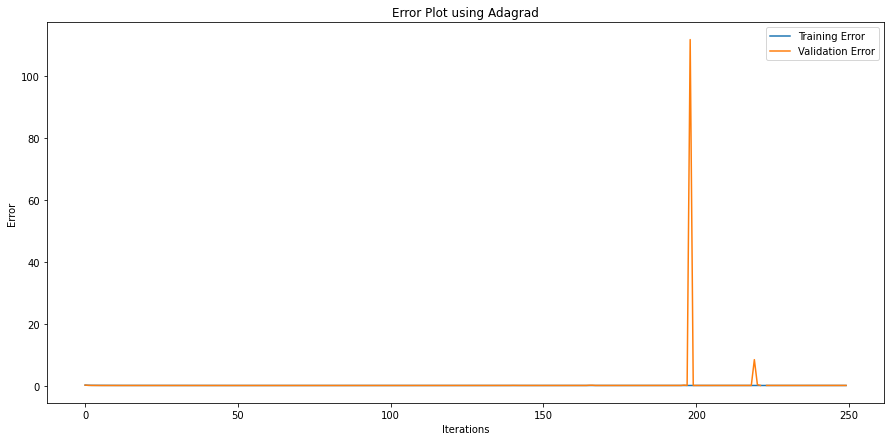

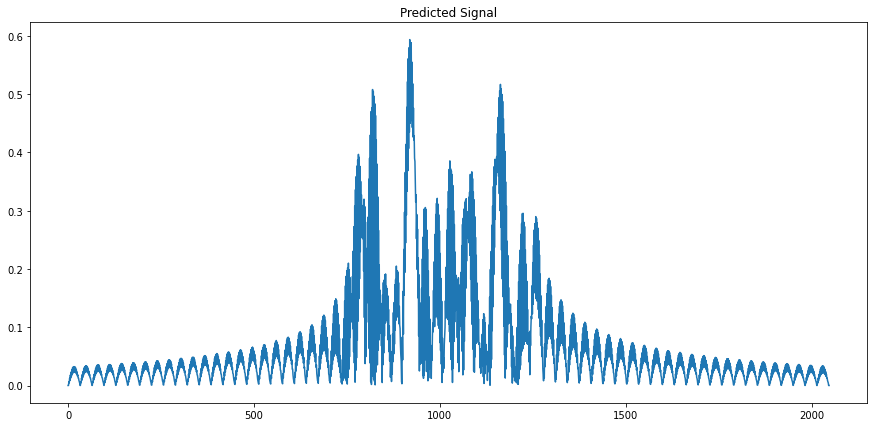

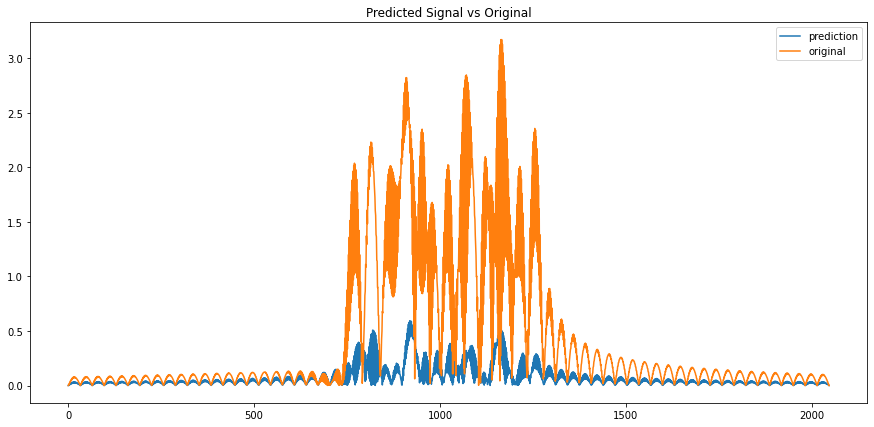

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.02it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
(1, 1024)


b :  [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1]
bhat :  [0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1]
ber :  0.328125
ser :  2.9768358096461336


In [163]:
index_pred= 0
y_pred = evals(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect, nsymbols=parameters.n)